## FINGER TAPPING ANALYSIS
##### Data collected from patients with neurodegenerative disorders as well as healthy controls

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import time
import sys
from tqdm import tqdm
import os
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import math
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import keras
from keras.models import Model, model_from_yaml
from keras.layers import Input, Conv1D, Flatten, Dropout, MaxPooling1D, Dense
from keras.layers import Activation, BatchNormalization, concatenate
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

# from IPython.display import Audio
# sound_file = './sound/beep.wav'

C:\Users\Vladislava\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read the data

train = scipy.io.loadmat('TrainData.mat')
val = scipy.io.loadmat('ValData.mat')


In [3]:
Xtrain, Ytrain = train['X'], train['Y']
Xval, Yval = val['X'], val['Y']

### Arite, lez make a model

In [4]:
def CNNModel(inputShape, nConvLayers):
    
    input1 = Input(shape = inputShape)

    #convolutions
    x = input1
    
    
    for i in range(0,nConvLayers):
        
        nFilters = 128 if i>1 else 32*(i+1)
        inside = 3 if i>1 else 2
        for temp in range(0,inside):
            x = Conv1D(filters = nFilters,
                  kernel_size = 5,
                  padding = 'same',
                  strides = 1,
                  name = 'Conv1x5{}{}'.format(i,temp))(x)
            
            x = Activation('relu',name='ReLu{}{}'.format(i,temp))(x)
            x = BatchNormalization()(x)
            
        x = MaxPooling1D(2,
                      padding = 'same',
                      strides = 1,
                      name = 'MaxPooling1D{}'.format(i))(x)
    
    x = Dropout(0.5)(x)
    
    # Fully connected
    x = Flatten()(x)
    
    x = Dense(128)(x)
    x = Activation('relu', name = 'reLU_dense')(x)
    x = Dropout(0.6)(x)
    
    x = Dense(4)(x)
    x = Activation('softmax',name = 'Softmax')(x)

    m = Model(input1,x)
    return m


In [6]:
def saveModelTopology(model,modelName):
    model_json = model.to_yaml()
    with open(modelName+'.yaml', "w") as yaml_file:
        yaml_file.write(model_json)
    print("Saved model to {}.yaml".format(modelName))
    return


In [7]:
def defCallbacks(weightFile):
    
    checkpoint = ModelCheckpoint(weightFile,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode='max')
    early = EarlyStopping(monitor='val_acc',
                          patience = 15,
                          verbose = 1,
                          mode='max')
    return [checkpoint, early]
    

In [8]:
def fitModel(model, modelName, Xtrain, Ytrain, Xval, Yval, epochs):
    
    tic = time.time()
    
    # make file name
    tm = time.gmtime()
    weightFile = 'BEST_WEIGHTS{}.{}.{}.{}.{}.{}.h5'.format(modelName,tm[2],tm[1],tm[0],tm[3]+1,tm[4])
    
    #define callbacks
    callbacks = defCallbacks(weightFile)
    
    # FIT THE MODEL
    history = model.fit(x = Xtrain, y = Ytrain,
                        epochs=epochs,
                        batch_size=8,
                        validation_data = (Xval,Yval),
                        callbacks = callbacks)
    toc = time.time()
    print("Finished training in {} min ({} h)".format(round((toc-tic)/60,2),round((toc-tic)/3600,2)))

    
    # Save the weights
    #model.save_weights(str(modelName)+'.h5') # ???????
    
    return history

In [9]:
# def evaluateModel(model, modelName, Xval, Yval):
#     tic = time.time()
#     predictions = model.predict(Xval)
#     toc = time.time()
#     print('Finished prediction in: {} min'.format(round((toc-tic)/60,2)))

#     print('Evaluating...')
#     score = model.evaluate(Xval,Yval,verbose=1)
#     print(score)

#     #Save that stuff too pls.
#     tm = time.gmtime()    
#     predictionFile = 'Predictions-{}.{}.{}.{}.{}.{}.csv'.format(modelName,tm[2],tm[1],tm[0],tm[3]+1,tm[4])

#     dfPredicted = pd.DataFrame(predictions)
#     dfPredicted = dfPredicted.idxmax(axis =1)
#     dfExpected = pd.DataFrame(Yval)
#     dfExpected = dfExpected.idxmax(axis =1)
#     df = pd.DataFrame({'Predicted':dfPredicted, 'Expected':dfExpected})
#     df.to_csv(predictionFile,index = False)
#     print('Saved predictions to: ', predictionFile)
    
#     bingos = sum(df['Predicted'] ==df['Expected'])
#     accRly = 100*bingos/df.shape[0]
#     print('Currently your actual accuracy on Xval is: {}%'.format(round(accRly,2)))
    
#     return accRly

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000, 6)           0         
_________________________________________________________________
Conv1x500 (Conv1D)           (None, 2000, 32)          992       
_________________________________________________________________
ReLu00 (Activation)          (None, 2000, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2000, 32)          128       
_________________________________________________________________
Conv1x501 (Conv1D)           (None, 2000, 32)          5152      
_________________________________________________________________
ReLu01 (Activation)          (None, 2000, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2000, 32)          128       
__________

1696/2719 [=================>............] - ETA: 22:07 - loss: 6.9410 - acc: 0.0000e+ - ETA: 11:22 - loss: 5.1167 - acc: 0.1875   - ETA: 7:46 - loss: 4.7594 - acc: 0.1667 - ETA: 5:58 - loss: 4.2279 - acc: 0.156 - ETA: 4:53 - loss: 4.6006 - acc: 0.175 - ETA: 4:09 - loss: 4.6213 - acc: 0.145 - ETA: 3:38 - loss: 4.8142 - acc: 0.125 - ETA: 3:15 - loss: 4.9694 - acc: 0.125 - ETA: 2:57 - loss: 4.7568 - acc: 0.194 - ETA: 2:42 - loss: 4.8857 - acc: 0.200 - ETA: 2:31 - loss: 4.8434 - acc: 0.193 - ETA: 2:21 - loss: 4.7569 - acc: 0.197 - ETA: 2:12 - loss: 4.6213 - acc: 0.211 - ETA: 2:05 - loss: 4.6870 - acc: 0.205 - ETA: 1:59 - loss: 4.6325 - acc: 0.208 - ETA: 1:53 - loss: 4.4659 - acc: 0.226 - ETA: 1:48 - loss: 4.4043 - acc: 0.220 - ETA: 1:44 - loss: 4.3976 - acc: 0.215 - ETA: 1:40 - loss: 4.3241 - acc: 0.210 - ETA: 1:37 - loss: 4.3596 - acc: 0.218 - ETA: 1:33 - loss: 4.2876 - acc: 0.214 - ETA: 1:30 - loss: 4.1810 - acc: 0.221 - ETA: 1:28 - loss: 4.0412 - acc: 0.239 - ETA: 1:25 - loss: 3.9922 -

1720/2719 [=================>............] - ETA: 44s - loss: 1.0246 - acc: 0.50 - ETA: 41s - loss: 1.0110 - acc: 0.62 - ETA: 41s - loss: 1.0227 - acc: 0.58 - ETA: 41s - loss: 1.0359 - acc: 0.56 - ETA: 39s - loss: 0.9831 - acc: 0.60 - ETA: 39s - loss: 0.9750 - acc: 0.60 - ETA: 39s - loss: 0.9906 - acc: 0.57 - ETA: 39s - loss: 0.9765 - acc: 0.57 - ETA: 38s - loss: 0.9659 - acc: 0.59 - ETA: 38s - loss: 0.9814 - acc: 0.56 - ETA: 38s - loss: 0.9900 - acc: 0.55 - ETA: 37s - loss: 1.0458 - acc: 0.53 - ETA: 37s - loss: 1.0853 - acc: 0.50 - ETA: 37s - loss: 1.1024 - acc: 0.50 - ETA: 37s - loss: 1.0912 - acc: 0.51 - ETA: 37s - loss: 1.0864 - acc: 0.53 - ETA: 36s - loss: 1.0619 - acc: 0.55 - ETA: 36s - loss: 1.0885 - acc: 0.53 - ETA: 36s - loss: 1.1117 - acc: 0.52 - ETA: 36s - loss: 1.0961 - acc: 0.52 - ETA: 36s - loss: 1.0865 - acc: 0.53 - ETA: 36s - loss: 1.0950 - acc: 0.52 - ETA: 36s - loss: 1.0778 - acc: 0.53 - ETA: 36s - loss: 1.0673 - acc: 0.54 - ETA: 35s - loss: 1.0480 - acc: 0.55 - ETA: 

2719/2719 [==============================] - ETA: 13s - loss: 1.0550 - acc: 0.53 - ETA: 13s - loss: 1.0532 - acc: 0.53 - ETA: 13s - loss: 1.0527 - acc: 0.53 - ETA: 13s - loss: 1.0530 - acc: 0.53 - ETA: 13s - loss: 1.0520 - acc: 0.53 - ETA: 13s - loss: 1.0505 - acc: 0.53 - ETA: 13s - loss: 1.0499 - acc: 0.53 - ETA: 13s - loss: 1.0491 - acc: 0.53 - ETA: 13s - loss: 1.0497 - acc: 0.53 - ETA: 12s - loss: 1.0491 - acc: 0.53 - ETA: 12s - loss: 1.0521 - acc: 0.53 - ETA: 12s - loss: 1.0518 - acc: 0.53 - ETA: 12s - loss: 1.0519 - acc: 0.53 - ETA: 12s - loss: 1.0522 - acc: 0.53 - ETA: 12s - loss: 1.0507 - acc: 0.53 - ETA: 12s - loss: 1.0493 - acc: 0.53 - ETA: 12s - loss: 1.0479 - acc: 0.53 - ETA: 12s - loss: 1.0478 - acc: 0.53 - ETA: 11s - loss: 1.0487 - acc: 0.53 - ETA: 11s - loss: 1.0474 - acc: 0.53 - ETA: 11s - loss: 1.0466 - acc: 0.53 - ETA: 11s - loss: 1.0462 - acc: 0.53 - ETA: 11s - loss: 1.0462 - acc: 0.53 - ETA: 11s - loss: 1.0452 - acc: 0.53 - ETA: 11s - loss: 1.0462 - acc: 0.53 - ETA: 

1720/2719 [=================>............] - ETA: 46s - loss: 0.9445 - acc: 0.75 - ETA: 42s - loss: 0.7291 - acc: 0.75 - ETA: 42s - loss: 0.6913 - acc: 0.75 - ETA: 41s - loss: 0.5890 - acc: 0.81 - ETA: 40s - loss: 0.5702 - acc: 0.77 - ETA: 40s - loss: 0.5886 - acc: 0.77 - ETA: 39s - loss: 0.5824 - acc: 0.78 - ETA: 39s - loss: 0.6130 - acc: 0.76 - ETA: 38s - loss: 0.5966 - acc: 0.76 - ETA: 38s - loss: 0.5827 - acc: 0.77 - ETA: 38s - loss: 0.5884 - acc: 0.77 - ETA: 38s - loss: 0.5786 - acc: 0.77 - ETA: 37s - loss: 0.5833 - acc: 0.75 - ETA: 37s - loss: 0.5611 - acc: 0.76 - ETA: 37s - loss: 0.5865 - acc: 0.75 - ETA: 37s - loss: 0.5845 - acc: 0.75 - ETA: 37s - loss: 0.6057 - acc: 0.75 - ETA: 37s - loss: 0.6531 - acc: 0.72 - ETA: 36s - loss: 0.6590 - acc: 0.73 - ETA: 36s - loss: 0.6668 - acc: 0.72 - ETA: 36s - loss: 0.6633 - acc: 0.72 - ETA: 36s - loss: 0.6747 - acc: 0.71 - ETA: 36s - loss: 0.6811 - acc: 0.71 - ETA: 36s - loss: 0.6802 - acc: 0.71 - ETA: 35s - loss: 0.6813 - acc: 0.72 - ETA: 

1720/2719 [=================>............] - ETA: 34s - loss: 0.5645 - acc: 0.75 - ETA: 36s - loss: 0.4422 - acc: 0.87 - ETA: 37s - loss: 0.5422 - acc: 0.75 - ETA: 37s - loss: 0.5449 - acc: 0.75 - ETA: 37s - loss: 0.5359 - acc: 0.75 - ETA: 37s - loss: 0.5979 - acc: 0.70 - ETA: 37s - loss: 0.5826 - acc: 0.73 - ETA: 37s - loss: 0.5756 - acc: 0.73 - ETA: 37s - loss: 0.6498 - acc: 0.73 - ETA: 37s - loss: 0.6150 - acc: 0.75 - ETA: 36s - loss: 0.6317 - acc: 0.73 - ETA: 36s - loss: 0.6174 - acc: 0.73 - ETA: 36s - loss: 0.6218 - acc: 0.74 - ETA: 36s - loss: 0.6080 - acc: 0.74 - ETA: 36s - loss: 0.5973 - acc: 0.75 - ETA: 36s - loss: 0.6190 - acc: 0.74 - ETA: 36s - loss: 0.6204 - acc: 0.74 - ETA: 36s - loss: 0.6201 - acc: 0.73 - ETA: 36s - loss: 0.6108 - acc: 0.75 - ETA: 35s - loss: 0.6082 - acc: 0.75 - ETA: 35s - loss: 0.6141 - acc: 0.75 - ETA: 35s - loss: 0.6014 - acc: 0.75 - ETA: 35s - loss: 0.5954 - acc: 0.75 - ETA: 35s - loss: 0.5854 - acc: 0.75 - ETA: 35s - loss: 0.5757 - acc: 0.75 - ETA: 

2719/2719 [==============================] - ETA: 14s - loss: 0.5934 - acc: 0.76 - ETA: 13s - loss: 0.5932 - acc: 0.76 - ETA: 13s - loss: 0.5930 - acc: 0.76 - ETA: 13s - loss: 0.5940 - acc: 0.76 - ETA: 13s - loss: 0.5938 - acc: 0.76 - ETA: 13s - loss: 0.5940 - acc: 0.76 - ETA: 13s - loss: 0.5944 - acc: 0.76 - ETA: 13s - loss: 0.5947 - acc: 0.76 - ETA: 13s - loss: 0.5945 - acc: 0.75 - ETA: 12s - loss: 0.5955 - acc: 0.75 - ETA: 12s - loss: 0.5954 - acc: 0.75 - ETA: 12s - loss: 0.5955 - acc: 0.75 - ETA: 12s - loss: 0.5948 - acc: 0.75 - ETA: 12s - loss: 0.5962 - acc: 0.75 - ETA: 12s - loss: 0.5987 - acc: 0.75 - ETA: 12s - loss: 0.5999 - acc: 0.75 - ETA: 12s - loss: 0.6000 - acc: 0.75 - ETA: 12s - loss: 0.5987 - acc: 0.75 - ETA: 11s - loss: 0.5987 - acc: 0.75 - ETA: 11s - loss: 0.5976 - acc: 0.75 - ETA: 11s - loss: 0.5973 - acc: 0.75 - ETA: 11s - loss: 0.5964 - acc: 0.75 - ETA: 11s - loss: 0.5964 - acc: 0.75 - ETA: 11s - loss: 0.5952 - acc: 0.75 - ETA: 11s - loss: 0.5935 - acc: 0.75 - ETA: 

1720/2719 [=================>............] - ETA: 40s - loss: 0.3321 - acc: 0.87 - ETA: 41s - loss: 0.4214 - acc: 0.75 - ETA: 40s - loss: 0.8756 - acc: 0.70 - ETA: 40s - loss: 0.7220 - acc: 0.78 - ETA: 39s - loss: 0.6823 - acc: 0.80 - ETA: 39s - loss: 0.6344 - acc: 0.81 - ETA: 38s - loss: 0.6692 - acc: 0.80 - ETA: 38s - loss: 0.6384 - acc: 0.81 - ETA: 38s - loss: 0.6033 - acc: 0.81 - ETA: 38s - loss: 0.5778 - acc: 0.81 - ETA: 37s - loss: 0.5357 - acc: 0.82 - ETA: 37s - loss: 0.5204 - acc: 0.83 - ETA: 37s - loss: 0.5312 - acc: 0.82 - ETA: 37s - loss: 0.5269 - acc: 0.83 - ETA: 37s - loss: 0.5664 - acc: 0.80 - ETA: 37s - loss: 0.5414 - acc: 0.82 - ETA: 37s - loss: 0.5172 - acc: 0.83 - ETA: 36s - loss: 0.4984 - acc: 0.83 - ETA: 36s - loss: 0.5025 - acc: 0.82 - ETA: 36s - loss: 0.5108 - acc: 0.81 - ETA: 36s - loss: 0.4904 - acc: 0.82 - ETA: 36s - loss: 0.5159 - acc: 0.81 - ETA: 36s - loss: 0.5029 - acc: 0.82 - ETA: 36s - loss: 0.4888 - acc: 0.82 - ETA: 35s - loss: 0.4844 - acc: 0.82 - ETA: 

1720/2719 [=================>............] - ETA: 36s - loss: 0.0572 - acc: 1.00 - ETA: 37s - loss: 0.1988 - acc: 0.93 - ETA: 38s - loss: 0.1489 - acc: 0.95 - ETA: 37s - loss: 0.1357 - acc: 0.96 - ETA: 37s - loss: 0.1377 - acc: 0.97 - ETA: 37s - loss: 0.2483 - acc: 0.91 - ETA: 37s - loss: 0.2668 - acc: 0.89 - ETA: 37s - loss: 0.3299 - acc: 0.85 - ETA: 37s - loss: 0.3699 - acc: 0.83 - ETA: 36s - loss: 0.3517 - acc: 0.83 - ETA: 37s - loss: 0.3413 - acc: 0.84 - ETA: 36s - loss: 0.3339 - acc: 0.84 - ETA: 36s - loss: 0.3256 - acc: 0.84 - ETA: 36s - loss: 0.3060 - acc: 0.85 - ETA: 36s - loss: 0.3093 - acc: 0.85 - ETA: 36s - loss: 0.3020 - acc: 0.85 - ETA: 36s - loss: 0.3052 - acc: 0.86 - ETA: 36s - loss: 0.3074 - acc: 0.86 - ETA: 36s - loss: 0.2943 - acc: 0.87 - ETA: 35s - loss: 0.3486 - acc: 0.86 - ETA: 35s - loss: 0.3400 - acc: 0.86 - ETA: 35s - loss: 0.3461 - acc: 0.85 - ETA: 35s - loss: 0.3458 - acc: 0.85 - ETA: 35s - loss: 0.3692 - acc: 0.85 - ETA: 35s - loss: 0.3637 - acc: 0.85 - ETA: 

2719/2719 [==============================] - ETA: 14s - loss: 0.3696 - acc: 0.86 - ETA: 13s - loss: 0.3690 - acc: 0.86 - ETA: 13s - loss: 0.3689 - acc: 0.86 - ETA: 13s - loss: 0.3682 - acc: 0.86 - ETA: 13s - loss: 0.3669 - acc: 0.86 - ETA: 13s - loss: 0.3667 - acc: 0.86 - ETA: 13s - loss: 0.3668 - acc: 0.86 - ETA: 13s - loss: 0.3670 - acc: 0.86 - ETA: 13s - loss: 0.3655 - acc: 0.86 - ETA: 12s - loss: 0.3649 - acc: 0.86 - ETA: 12s - loss: 0.3642 - acc: 0.86 - ETA: 12s - loss: 0.3642 - acc: 0.86 - ETA: 12s - loss: 0.3629 - acc: 0.86 - ETA: 12s - loss: 0.3640 - acc: 0.86 - ETA: 12s - loss: 0.3644 - acc: 0.86 - ETA: 12s - loss: 0.3632 - acc: 0.86 - ETA: 12s - loss: 0.3637 - acc: 0.86 - ETA: 12s - loss: 0.3634 - acc: 0.86 - ETA: 11s - loss: 0.3627 - acc: 0.86 - ETA: 11s - loss: 0.3626 - acc: 0.86 - ETA: 11s - loss: 0.3682 - acc: 0.86 - ETA: 11s - loss: 0.3679 - acc: 0.86 - ETA: 11s - loss: 0.3675 - acc: 0.86 - ETA: 11s - loss: 0.3680 - acc: 0.86 - ETA: 11s - loss: 0.3673 - acc: 0.86 - ETA: 

1720/2719 [=================>............] - ETA: 36s - loss: 0.1750 - acc: 1.00 - ETA: 37s - loss: 0.2315 - acc: 0.93 - ETA: 37s - loss: 0.2733 - acc: 0.91 - ETA: 37s - loss: 0.2368 - acc: 0.93 - ETA: 37s - loss: 0.2399 - acc: 0.92 - ETA: 37s - loss: 0.2232 - acc: 0.93 - ETA: 37s - loss: 0.2049 - acc: 0.94 - ETA: 37s - loss: 0.1878 - acc: 0.95 - ETA: 37s - loss: 0.2003 - acc: 0.95 - ETA: 37s - loss: 0.1902 - acc: 0.96 - ETA: 36s - loss: 0.2011 - acc: 0.95 - ETA: 36s - loss: 0.2135 - acc: 0.94 - ETA: 36s - loss: 0.2120 - acc: 0.95 - ETA: 36s - loss: 0.2473 - acc: 0.94 - ETA: 36s - loss: 0.2344 - acc: 0.95 - ETA: 36s - loss: 0.2252 - acc: 0.95 - ETA: 36s - loss: 0.2404 - acc: 0.94 - ETA: 36s - loss: 0.2273 - acc: 0.94 - ETA: 36s - loss: 0.2296 - acc: 0.94 - ETA: 36s - loss: 0.2437 - acc: 0.93 - ETA: 35s - loss: 0.2508 - acc: 0.93 - ETA: 35s - loss: 0.2470 - acc: 0.93 - ETA: 35s - loss: 0.2512 - acc: 0.93 - ETA: 35s - loss: 0.2448 - acc: 0.93 - ETA: 35s - loss: 0.2488 - acc: 0.94 - ETA: 

1720/2719 [=================>............] - ETA: 45s - loss: 0.0866 - acc: 1.00 - ETA: 42s - loss: 0.1618 - acc: 0.93 - ETA: 41s - loss: 0.1968 - acc: 0.91 - ETA: 40s - loss: 0.1877 - acc: 0.93 - ETA: 40s - loss: 0.1877 - acc: 0.95 - ETA: 39s - loss: 0.1643 - acc: 0.95 - ETA: 39s - loss: 0.1577 - acc: 0.96 - ETA: 38s - loss: 0.1510 - acc: 0.96 - ETA: 38s - loss: 0.2034 - acc: 0.95 - ETA: 38s - loss: 0.1872 - acc: 0.96 - ETA: 38s - loss: 0.1976 - acc: 0.95 - ETA: 37s - loss: 0.1833 - acc: 0.95 - ETA: 37s - loss: 0.1787 - acc: 0.96 - ETA: 37s - loss: 0.1771 - acc: 0.96 - ETA: 37s - loss: 0.1826 - acc: 0.95 - ETA: 37s - loss: 0.1737 - acc: 0.96 - ETA: 37s - loss: 0.1779 - acc: 0.95 - ETA: 36s - loss: 0.1721 - acc: 0.95 - ETA: 36s - loss: 0.2227 - acc: 0.94 - ETA: 36s - loss: 0.2155 - acc: 0.94 - ETA: 36s - loss: 0.2071 - acc: 0.94 - ETA: 36s - loss: 0.2063 - acc: 0.94 - ETA: 36s - loss: 0.2027 - acc: 0.94 - ETA: 36s - loss: 0.2096 - acc: 0.94 - ETA: 36s - loss: 0.2169 - acc: 0.93 - ETA: 

2719/2719 [==============================] - ETA: 14s - loss: 0.2212 - acc: 0.92 - ETA: 13s - loss: 0.2203 - acc: 0.92 - ETA: 13s - loss: 0.2200 - acc: 0.92 - ETA: 13s - loss: 0.2207 - acc: 0.92 - ETA: 13s - loss: 0.2199 - acc: 0.92 - ETA: 13s - loss: 0.2197 - acc: 0.92 - ETA: 13s - loss: 0.2197 - acc: 0.92 - ETA: 13s - loss: 0.2209 - acc: 0.92 - ETA: 13s - loss: 0.2206 - acc: 0.92 - ETA: 13s - loss: 0.2209 - acc: 0.92 - ETA: 12s - loss: 0.2202 - acc: 0.92 - ETA: 12s - loss: 0.2201 - acc: 0.92 - ETA: 12s - loss: 0.2206 - acc: 0.92 - ETA: 12s - loss: 0.2197 - acc: 0.92 - ETA: 12s - loss: 0.2191 - acc: 0.92 - ETA: 12s - loss: 0.2189 - acc: 0.92 - ETA: 12s - loss: 0.2180 - acc: 0.92 - ETA: 12s - loss: 0.2191 - acc: 0.92 - ETA: 11s - loss: 0.2238 - acc: 0.92 - ETA: 11s - loss: 0.2241 - acc: 0.92 - ETA: 11s - loss: 0.2300 - acc: 0.92 - ETA: 11s - loss: 0.2308 - acc: 0.91 - ETA: 11s - loss: 0.2306 - acc: 0.91 - ETA: 11s - loss: 0.2298 - acc: 0.92 - ETA: 11s - loss: 0.2291 - acc: 0.92 - ETA: 

1720/2719 [=================>............] - ETA: 36s - loss: 0.0173 - acc: 1.00 - ETA: 37s - loss: 0.0866 - acc: 1.00 - ETA: 37s - loss: 0.1198 - acc: 1.00 - ETA: 37s - loss: 0.1368 - acc: 0.96 - ETA: 37s - loss: 0.1788 - acc: 0.92 - ETA: 37s - loss: 0.1642 - acc: 0.93 - ETA: 37s - loss: 0.1612 - acc: 0.94 - ETA: 37s - loss: 0.1575 - acc: 0.95 - ETA: 37s - loss: 0.1449 - acc: 0.95 - ETA: 36s - loss: 0.1336 - acc: 0.96 - ETA: 36s - loss: 0.1403 - acc: 0.95 - ETA: 36s - loss: 0.1505 - acc: 0.94 - ETA: 36s - loss: 0.1501 - acc: 0.94 - ETA: 36s - loss: 0.1412 - acc: 0.94 - ETA: 36s - loss: 0.1439 - acc: 0.94 - ETA: 36s - loss: 0.1378 - acc: 0.94 - ETA: 36s - loss: 0.1890 - acc: 0.92 - ETA: 36s - loss: 0.1806 - acc: 0.93 - ETA: 36s - loss: 0.1739 - acc: 0.93 - ETA: 36s - loss: 0.1720 - acc: 0.93 - ETA: 35s - loss: 0.1910 - acc: 0.93 - ETA: 35s - loss: 0.1921 - acc: 0.93 - ETA: 35s - loss: 0.1873 - acc: 0.93 - ETA: 35s - loss: 0.2099 - acc: 0.92 - ETA: 35s - loss: 0.2139 - acc: 0.92 - ETA: 

1720/2719 [=================>............] - ETA: 37s - loss: 0.4410 - acc: 0.75 - ETA: 36s - loss: 0.2898 - acc: 0.87 - ETA: 37s - loss: 0.3041 - acc: 0.87 - ETA: 37s - loss: 0.2753 - acc: 0.87 - ETA: 36s - loss: 0.2613 - acc: 0.87 - ETA: 37s - loss: 0.2422 - acc: 0.89 - ETA: 37s - loss: 0.2469 - acc: 0.89 - ETA: 37s - loss: 0.2188 - acc: 0.90 - ETA: 37s - loss: 0.1976 - acc: 0.91 - ETA: 37s - loss: 0.2025 - acc: 0.91 - ETA: 36s - loss: 0.1859 - acc: 0.92 - ETA: 36s - loss: 0.1720 - acc: 0.92 - ETA: 36s - loss: 0.1746 - acc: 0.92 - ETA: 36s - loss: 0.2539 - acc: 0.91 - ETA: 36s - loss: 0.2399 - acc: 0.92 - ETA: 36s - loss: 0.2526 - acc: 0.91 - ETA: 36s - loss: 0.2444 - acc: 0.91 - ETA: 36s - loss: 0.2424 - acc: 0.91 - ETA: 36s - loss: 0.2335 - acc: 0.92 - ETA: 35s - loss: 0.2413 - acc: 0.91 - ETA: 35s - loss: 0.2329 - acc: 0.92 - ETA: 35s - loss: 0.2277 - acc: 0.92 - ETA: 35s - loss: 0.2243 - acc: 0.92 - ETA: 35s - loss: 0.2156 - acc: 0.92 - ETA: 35s - loss: 0.2092 - acc: 0.93 - ETA: 

2719/2719 [==============================] - ETA: 14s - loss: 0.1717 - acc: 0.93 - ETA: 13s - loss: 0.1715 - acc: 0.93 - ETA: 13s - loss: 0.1713 - acc: 0.93 - ETA: 13s - loss: 0.1711 - acc: 0.93 - ETA: 13s - loss: 0.1709 - acc: 0.93 - ETA: 13s - loss: 0.1705 - acc: 0.93 - ETA: 13s - loss: 0.1699 - acc: 0.93 - ETA: 13s - loss: 0.1695 - acc: 0.93 - ETA: 13s - loss: 0.1688 - acc: 0.93 - ETA: 12s - loss: 0.1681 - acc: 0.93 - ETA: 12s - loss: 0.1676 - acc: 0.93 - ETA: 12s - loss: 0.1671 - acc: 0.93 - ETA: 12s - loss: 0.1676 - acc: 0.93 - ETA: 12s - loss: 0.1669 - acc: 0.93 - ETA: 12s - loss: 0.1670 - acc: 0.93 - ETA: 12s - loss: 0.1691 - acc: 0.93 - ETA: 12s - loss: 0.1692 - acc: 0.93 - ETA: 12s - loss: 0.1687 - acc: 0.93 - ETA: 11s - loss: 0.1681 - acc: 0.93 - ETA: 11s - loss: 0.1676 - acc: 0.93 - ETA: 11s - loss: 0.1670 - acc: 0.94 - ETA: 11s - loss: 0.1671 - acc: 0.93 - ETA: 11s - loss: 0.1665 - acc: 0.94 - ETA: 11s - loss: 0.1660 - acc: 0.94 - ETA: 11s - loss: 0.1666 - acc: 0.94 - ETA: 

1720/2719 [=================>............] - ETA: 41s - loss: 0.0093 - acc: 1.00 - ETA: 40s - loss: 0.0317 - acc: 1.00 - ETA: 39s - loss: 0.1461 - acc: 0.95 - ETA: 39s - loss: 0.1212 - acc: 0.96 - ETA: 38s - loss: 0.1005 - acc: 0.97 - ETA: 38s - loss: 0.1037 - acc: 0.97 - ETA: 38s - loss: 0.0949 - acc: 0.98 - ETA: 38s - loss: 0.0919 - acc: 0.98 - ETA: 38s - loss: 0.0827 - acc: 0.98 - ETA: 37s - loss: 0.1058 - acc: 0.97 - ETA: 37s - loss: 0.1151 - acc: 0.96 - ETA: 37s - loss: 0.1079 - acc: 0.96 - ETA: 37s - loss: 0.1224 - acc: 0.96 - ETA: 37s - loss: 0.1205 - acc: 0.96 - ETA: 37s - loss: 0.1401 - acc: 0.95 - ETA: 36s - loss: 0.1337 - acc: 0.96 - ETA: 36s - loss: 0.1276 - acc: 0.96 - ETA: 36s - loss: 0.1253 - acc: 0.96 - ETA: 36s - loss: 0.1285 - acc: 0.96 - ETA: 36s - loss: 0.1238 - acc: 0.96 - ETA: 36s - loss: 0.1184 - acc: 0.96 - ETA: 36s - loss: 0.1134 - acc: 0.96 - ETA: 36s - loss: 0.1559 - acc: 0.95 - ETA: 35s - loss: 0.1496 - acc: 0.95 - ETA: 35s - loss: 0.1699 - acc: 0.94 - ETA: 

1720/2719 [=================>............] - ETA: 37s - loss: 0.0012 - acc: 1.00 - ETA: 36s - loss: 0.0200 - acc: 1.00 - ETA: 37s - loss: 0.0310 - acc: 1.00 - ETA: 37s - loss: 0.0561 - acc: 0.96 - ETA: 37s - loss: 0.0481 - acc: 0.97 - ETA: 37s - loss: 0.0451 - acc: 0.97 - ETA: 37s - loss: 0.1382 - acc: 0.96 - ETA: 37s - loss: 0.1217 - acc: 0.96 - ETA: 37s - loss: 0.1410 - acc: 0.95 - ETA: 37s - loss: 0.1611 - acc: 0.95 - ETA: 36s - loss: 0.1551 - acc: 0.95 - ETA: 36s - loss: 0.1471 - acc: 0.95 - ETA: 36s - loss: 0.1376 - acc: 0.96 - ETA: 36s - loss: 0.1377 - acc: 0.96 - ETA: 36s - loss: 0.1299 - acc: 0.96 - ETA: 36s - loss: 0.1228 - acc: 0.96 - ETA: 36s - loss: 0.1436 - acc: 0.95 - ETA: 36s - loss: 0.1541 - acc: 0.95 - ETA: 36s - loss: 0.1596 - acc: 0.94 - ETA: 35s - loss: 0.1617 - acc: 0.94 - ETA: 35s - loss: 0.1549 - acc: 0.94 - ETA: 35s - loss: 0.1492 - acc: 0.94 - ETA: 35s - loss: 0.1508 - acc: 0.94 - ETA: 35s - loss: 0.1459 - acc: 0.94 - ETA: 35s - loss: 0.1635 - acc: 0.94 - ETA: 

2719/2719 [==============================] - ETA: 14s - loss: 0.1647 - acc: 0.95 - ETA: 13s - loss: 0.1642 - acc: 0.95 - ETA: 13s - loss: 0.1635 - acc: 0.95 - ETA: 13s - loss: 0.1628 - acc: 0.95 - ETA: 13s - loss: 0.1623 - acc: 0.95 - ETA: 13s - loss: 0.1629 - acc: 0.95 - ETA: 13s - loss: 0.1635 - acc: 0.95 - ETA: 13s - loss: 0.1628 - acc: 0.95 - ETA: 13s - loss: 0.1624 - acc: 0.95 - ETA: 12s - loss: 0.1622 - acc: 0.95 - ETA: 12s - loss: 0.1622 - acc: 0.95 - ETA: 12s - loss: 0.1615 - acc: 0.95 - ETA: 12s - loss: 0.1609 - acc: 0.95 - ETA: 12s - loss: 0.1617 - acc: 0.95 - ETA: 12s - loss: 0.1615 - acc: 0.95 - ETA: 12s - loss: 0.1612 - acc: 0.95 - ETA: 12s - loss: 0.1605 - acc: 0.95 - ETA: 12s - loss: 0.1601 - acc: 0.95 - ETA: 11s - loss: 0.1594 - acc: 0.95 - ETA: 11s - loss: 0.1606 - acc: 0.95 - ETA: 11s - loss: 0.1605 - acc: 0.95 - ETA: 11s - loss: 0.1600 - acc: 0.95 - ETA: 11s - loss: 0.1599 - acc: 0.95 - ETA: 11s - loss: 0.1592 - acc: 0.95 - ETA: 11s - loss: 0.1587 - acc: 0.95 - ETA: 

1720/2719 [=================>............] - ETA: 36s - loss: 0.0423 - acc: 1.00 - ETA: 37s - loss: 0.0300 - acc: 1.00 - ETA: 37s - loss: 0.1057 - acc: 0.95 - ETA: 37s - loss: 0.1416 - acc: 0.93 - ETA: 37s - loss: 0.1143 - acc: 0.95 - ETA: 37s - loss: 0.0953 - acc: 0.95 - ETA: 37s - loss: 0.1384 - acc: 0.94 - ETA: 37s - loss: 0.2765 - acc: 0.92 - ETA: 37s - loss: 0.2622 - acc: 0.93 - ETA: 37s - loss: 0.2399 - acc: 0.93 - ETA: 37s - loss: 0.2194 - acc: 0.94 - ETA: 37s - loss: 0.2068 - acc: 0.94 - ETA: 36s - loss: 0.1920 - acc: 0.95 - ETA: 36s - loss: 0.1903 - acc: 0.94 - ETA: 36s - loss: 0.1836 - acc: 0.95 - ETA: 36s - loss: 0.1831 - acc: 0.94 - ETA: 36s - loss: 0.1736 - acc: 0.94 - ETA: 36s - loss: 0.1924 - acc: 0.94 - ETA: 36s - loss: 0.1829 - acc: 0.94 - ETA: 36s - loss: 0.1740 - acc: 0.95 - ETA: 36s - loss: 0.1687 - acc: 0.95 - ETA: 35s - loss: 0.1779 - acc: 0.94 - ETA: 35s - loss: 0.1965 - acc: 0.94 - ETA: 35s - loss: 0.1962 - acc: 0.94 - ETA: 35s - loss: 0.1895 - acc: 0.94 - ETA: 

1720/2719 [=================>............] - ETA: 44s - loss: 0.0052 - acc: 1.00 - ETA: 41s - loss: 0.2483 - acc: 0.93 - ETA: 41s - loss: 0.1678 - acc: 0.95 - ETA: 40s - loss: 0.1329 - acc: 0.96 - ETA: 40s - loss: 0.1293 - acc: 0.97 - ETA: 39s - loss: 0.1085 - acc: 0.97 - ETA: 39s - loss: 0.0961 - acc: 0.98 - ETA: 38s - loss: 0.0858 - acc: 0.98 - ETA: 38s - loss: 0.1228 - acc: 0.97 - ETA: 38s - loss: 0.1157 - acc: 0.97 - ETA: 38s - loss: 0.1067 - acc: 0.97 - ETA: 38s - loss: 0.1052 - acc: 0.97 - ETA: 37s - loss: 0.1138 - acc: 0.97 - ETA: 37s - loss: 0.1294 - acc: 0.95 - ETA: 37s - loss: 0.1231 - acc: 0.95 - ETA: 37s - loss: 0.1156 - acc: 0.96 - ETA: 37s - loss: 0.1089 - acc: 0.96 - ETA: 36s - loss: 0.1218 - acc: 0.95 - ETA: 36s - loss: 0.1215 - acc: 0.96 - ETA: 36s - loss: 0.1219 - acc: 0.96 - ETA: 36s - loss: 0.1181 - acc: 0.96 - ETA: 36s - loss: 0.1136 - acc: 0.96 - ETA: 36s - loss: 0.1088 - acc: 0.96 - ETA: 36s - loss: 0.1260 - acc: 0.96 - ETA: 35s - loss: 0.1273 - acc: 0.96 - ETA: 

2719/2719 [==============================] - ETA: 14s - loss: 0.1226 - acc: 0.95 - ETA: 13s - loss: 0.1221 - acc: 0.95 - ETA: 13s - loss: 0.1217 - acc: 0.95 - ETA: 13s - loss: 0.1212 - acc: 0.95 - ETA: 13s - loss: 0.1225 - acc: 0.95 - ETA: 13s - loss: 0.1219 - acc: 0.95 - ETA: 13s - loss: 0.1218 - acc: 0.95 - ETA: 13s - loss: 0.1213 - acc: 0.95 - ETA: 13s - loss: 0.1208 - acc: 0.95 - ETA: 13s - loss: 0.1230 - acc: 0.95 - ETA: 12s - loss: 0.1224 - acc: 0.95 - ETA: 12s - loss: 0.1226 - acc: 0.95 - ETA: 12s - loss: 0.1240 - acc: 0.95 - ETA: 12s - loss: 0.1236 - acc: 0.95 - ETA: 12s - loss: 0.1231 - acc: 0.95 - ETA: 12s - loss: 0.1225 - acc: 0.95 - ETA: 12s - loss: 0.1221 - acc: 0.95 - ETA: 12s - loss: 0.1216 - acc: 0.95 - ETA: 11s - loss: 0.1211 - acc: 0.95 - ETA: 11s - loss: 0.1206 - acc: 0.96 - ETA: 11s - loss: 0.1208 - acc: 0.95 - ETA: 11s - loss: 0.1205 - acc: 0.95 - ETA: 11s - loss: 0.1200 - acc: 0.96 - ETA: 11s - loss: 0.1195 - acc: 0.96 - ETA: 11s - loss: 0.1200 - acc: 0.95 - ETA: 

1720/2719 [=================>............] - ETA: 34s - loss: 0.0143 - acc: 1.00 - ETA: 36s - loss: 0.0174 - acc: 1.00 - ETA: 37s - loss: 0.1451 - acc: 0.95 - ETA: 37s - loss: 0.1124 - acc: 0.96 - ETA: 37s - loss: 0.0901 - acc: 0.97 - ETA: 37s - loss: 0.1208 - acc: 0.95 - ETA: 37s - loss: 0.1336 - acc: 0.94 - ETA: 37s - loss: 0.1302 - acc: 0.95 - ETA: 37s - loss: 0.1172 - acc: 0.95 - ETA: 37s - loss: 0.1220 - acc: 0.95 - ETA: 36s - loss: 0.1112 - acc: 0.95 - ETA: 36s - loss: 0.1110 - acc: 0.94 - ETA: 36s - loss: 0.1025 - acc: 0.95 - ETA: 36s - loss: 0.0953 - acc: 0.95 - ETA: 36s - loss: 0.0891 - acc: 0.95 - ETA: 36s - loss: 0.0854 - acc: 0.96 - ETA: 36s - loss: 0.0816 - acc: 0.96 - ETA: 36s - loss: 0.0806 - acc: 0.96 - ETA: 36s - loss: 0.0815 - acc: 0.96 - ETA: 36s - loss: 0.0794 - acc: 0.96 - ETA: 35s - loss: 0.0756 - acc: 0.97 - ETA: 35s - loss: 0.0807 - acc: 0.96 - ETA: 35s - loss: 0.0798 - acc: 0.96 - ETA: 35s - loss: 0.0778 - acc: 0.96 - ETA: 35s - loss: 0.0756 - acc: 0.97 - ETA: 

1720/2719 [=================>............] - ETA: 36s - loss: 0.0081 - acc: 1.00 - ETA: 36s - loss: 0.0451 - acc: 1.00 - ETA: 37s - loss: 0.0663 - acc: 0.95 - ETA: 37s - loss: 0.0824 - acc: 0.93 - ETA: 37s - loss: 0.0778 - acc: 0.95 - ETA: 37s - loss: 0.1168 - acc: 0.91 - ETA: 37s - loss: 0.1035 - acc: 0.92 - ETA: 36s - loss: 0.0980 - acc: 0.93 - ETA: 37s - loss: 0.0904 - acc: 0.94 - ETA: 37s - loss: 0.0819 - acc: 0.95 - ETA: 36s - loss: 0.0775 - acc: 0.95 - ETA: 36s - loss: 0.0728 - acc: 0.95 - ETA: 36s - loss: 0.0678 - acc: 0.96 - ETA: 36s - loss: 0.0640 - acc: 0.96 - ETA: 36s - loss: 0.0617 - acc: 0.96 - ETA: 36s - loss: 0.1074 - acc: 0.96 - ETA: 36s - loss: 0.1045 - acc: 0.96 - ETA: 36s - loss: 0.1168 - acc: 0.95 - ETA: 36s - loss: 0.1108 - acc: 0.95 - ETA: 35s - loss: 0.1178 - acc: 0.95 - ETA: 35s - loss: 0.1144 - acc: 0.95 - ETA: 35s - loss: 0.1103 - acc: 0.95 - ETA: 35s - loss: 0.1193 - acc: 0.95 - ETA: 35s - loss: 0.1156 - acc: 0.95 - ETA: 35s - loss: 0.1127 - acc: 0.95 - ETA: 

2719/2719 [==============================] - ETA: 14s - loss: 0.1015 - acc: 0.95 - ETA: 13s - loss: 0.1013 - acc: 0.95 - ETA: 13s - loss: 0.1008 - acc: 0.95 - ETA: 13s - loss: 0.1009 - acc: 0.95 - ETA: 13s - loss: 0.1004 - acc: 0.95 - ETA: 13s - loss: 0.1001 - acc: 0.95 - ETA: 13s - loss: 0.0999 - acc: 0.95 - ETA: 13s - loss: 0.0998 - acc: 0.95 - ETA: 13s - loss: 0.1005 - acc: 0.95 - ETA: 12s - loss: 0.1002 - acc: 0.95 - ETA: 12s - loss: 0.0998 - acc: 0.95 - ETA: 12s - loss: 0.0994 - acc: 0.95 - ETA: 12s - loss: 0.0990 - acc: 0.95 - ETA: 12s - loss: 0.0986 - acc: 0.95 - ETA: 12s - loss: 0.0982 - acc: 0.95 - ETA: 12s - loss: 0.0982 - acc: 0.95 - ETA: 12s - loss: 0.1054 - acc: 0.95 - ETA: 12s - loss: 0.1051 - acc: 0.95 - ETA: 11s - loss: 0.1052 - acc: 0.95 - ETA: 11s - loss: 0.1063 - acc: 0.95 - ETA: 11s - loss: 0.1064 - acc: 0.95 - ETA: 11s - loss: 0.1077 - acc: 0.95 - ETA: 11s - loss: 0.1074 - acc: 0.95 - ETA: 11s - loss: 0.1086 - acc: 0.95 - ETA: 11s - loss: 0.1096 - acc: 0.95 - ETA: 

1720/2719 [=================>............] - ETA: 42s - loss: 0.0336 - acc: 1.00 - ETA: 41s - loss: 0.0203 - acc: 1.00 - ETA: 41s - loss: 0.0225 - acc: 1.00 - ETA: 40s - loss: 0.0956 - acc: 0.96 - ETA: 39s - loss: 0.1299 - acc: 0.95 - ETA: 39s - loss: 0.1154 - acc: 0.95 - ETA: 39s - loss: 0.0989 - acc: 0.96 - ETA: 38s - loss: 0.0943 - acc: 0.96 - ETA: 38s - loss: 0.1171 - acc: 0.94 - ETA: 38s - loss: 0.1056 - acc: 0.95 - ETA: 38s - loss: 0.1182 - acc: 0.94 - ETA: 38s - loss: 0.1116 - acc: 0.94 - ETA: 37s - loss: 0.1031 - acc: 0.95 - ETA: 37s - loss: 0.1124 - acc: 0.94 - ETA: 37s - loss: 0.1146 - acc: 0.94 - ETA: 37s - loss: 0.1083 - acc: 0.94 - ETA: 37s - loss: 0.1032 - acc: 0.94 - ETA: 36s - loss: 0.0975 - acc: 0.95 - ETA: 36s - loss: 0.0944 - acc: 0.95 - ETA: 36s - loss: 0.1137 - acc: 0.95 - ETA: 36s - loss: 0.1083 - acc: 0.95 - ETA: 36s - loss: 0.1034 - acc: 0.95 - ETA: 36s - loss: 0.1007 - acc: 0.95 - ETA: 36s - loss: 0.0966 - acc: 0.95 - ETA: 35s - loss: 0.1039 - acc: 0.95 - ETA: 

1720/2719 [=================>............] - ETA: 43s - loss: 0.0015 - acc: 1.00 - ETA: 41s - loss: 0.0060 - acc: 1.00 - ETA: 41s - loss: 0.0119 - acc: 1.00 - ETA: 40s - loss: 0.0106 - acc: 1.00 - ETA: 40s - loss: 0.0383 - acc: 0.97 - ETA: 39s - loss: 0.0351 - acc: 0.97 - ETA: 39s - loss: 0.0403 - acc: 0.98 - ETA: 39s - loss: 0.0363 - acc: 0.98 - ETA: 38s - loss: 0.0324 - acc: 0.98 - ETA: 38s - loss: 0.0303 - acc: 0.98 - ETA: 38s - loss: 0.0289 - acc: 0.98 - ETA: 37s - loss: 0.0323 - acc: 0.98 - ETA: 37s - loss: 0.0479 - acc: 0.98 - ETA: 37s - loss: 0.0477 - acc: 0.98 - ETA: 37s - loss: 0.0492 - acc: 0.98 - ETA: 37s - loss: 0.0514 - acc: 0.98 - ETA: 37s - loss: 0.0539 - acc: 0.98 - ETA: 36s - loss: 0.0667 - acc: 0.97 - ETA: 36s - loss: 0.0645 - acc: 0.98 - ETA: 36s - loss: 0.0747 - acc: 0.97 - ETA: 36s - loss: 0.0712 - acc: 0.97 - ETA: 36s - loss: 0.0816 - acc: 0.97 - ETA: 36s - loss: 0.0793 - acc: 0.97 - ETA: 36s - loss: 0.0762 - acc: 0.97 - ETA: 36s - loss: 0.0741 - acc: 0.97 - ETA: 

2719/2719 [==============================] - ETA: 14s - loss: 0.0739 - acc: 0.97 - ETA: 13s - loss: 0.0736 - acc: 0.97 - ETA: 13s - loss: 0.0732 - acc: 0.97 - ETA: 13s - loss: 0.0729 - acc: 0.97 - ETA: 13s - loss: 0.0727 - acc: 0.97 - ETA: 13s - loss: 0.0724 - acc: 0.97 - ETA: 13s - loss: 0.0720 - acc: 0.97 - ETA: 13s - loss: 0.0717 - acc: 0.97 - ETA: 13s - loss: 0.0714 - acc: 0.97 - ETA: 13s - loss: 0.0731 - acc: 0.97 - ETA: 12s - loss: 0.0734 - acc: 0.97 - ETA: 12s - loss: 0.0733 - acc: 0.97 - ETA: 12s - loss: 0.0730 - acc: 0.97 - ETA: 12s - loss: 0.0729 - acc: 0.97 - ETA: 12s - loss: 0.0726 - acc: 0.97 - ETA: 12s - loss: 0.0723 - acc: 0.97 - ETA: 12s - loss: 0.0720 - acc: 0.97 - ETA: 12s - loss: 0.0718 - acc: 0.97 - ETA: 11s - loss: 0.0715 - acc: 0.97 - ETA: 11s - loss: 0.0713 - acc: 0.97 - ETA: 11s - loss: 0.0712 - acc: 0.97 - ETA: 11s - loss: 0.0715 - acc: 0.97 - ETA: 11s - loss: 0.0716 - acc: 0.97 - ETA: 11s - loss: 0.0713 - acc: 0.97 - ETA: 11s - loss: 0.0710 - acc: 0.97 - ETA: 

1720/2719 [=================>............] - ETA: 35s - loss: 0.0044 - acc: 1.00 - ETA: 36s - loss: 0.0101 - acc: 1.00 - ETA: 37s - loss: 0.0160 - acc: 1.00 - ETA: 37s - loss: 0.0156 - acc: 1.00 - ETA: 37s - loss: 0.0148 - acc: 1.00 - ETA: 37s - loss: 0.0150 - acc: 1.00 - ETA: 37s - loss: 0.0209 - acc: 1.00 - ETA: 37s - loss: 0.0183 - acc: 1.00 - ETA: 37s - loss: 0.0183 - acc: 1.00 - ETA: 37s - loss: 0.0441 - acc: 0.98 - ETA: 36s - loss: 0.0447 - acc: 0.98 - ETA: 36s - loss: 0.0410 - acc: 0.98 - ETA: 36s - loss: 0.0563 - acc: 0.98 - ETA: 36s - loss: 0.0531 - acc: 0.98 - ETA: 36s - loss: 0.0562 - acc: 0.98 - ETA: 36s - loss: 0.0536 - acc: 0.98 - ETA: 36s - loss: 0.0505 - acc: 0.98 - ETA: 36s - loss: 0.0495 - acc: 0.98 - ETA: 36s - loss: 0.0470 - acc: 0.98 - ETA: 36s - loss: 0.0447 - acc: 0.98 - ETA: 35s - loss: 0.0426 - acc: 0.98 - ETA: 35s - loss: 0.0414 - acc: 0.98 - ETA: 35s - loss: 0.0403 - acc: 0.98 - ETA: 35s - loss: 0.0457 - acc: 0.98 - ETA: 35s - loss: 0.0506 - acc: 0.98 - ETA: 

1720/2719 [=================>............] - ETA: 36s - loss: 0.0034 - acc: 1.00 - ETA: 37s - loss: 0.0031 - acc: 1.00 - ETA: 36s - loss: 0.0063 - acc: 1.00 - ETA: 37s - loss: 0.0054 - acc: 1.00 - ETA: 37s - loss: 0.0044 - acc: 1.00 - ETA: 37s - loss: 0.0036 - acc: 1.00 - ETA: 37s - loss: 0.0685 - acc: 0.98 - ETA: 37s - loss: 0.0600 - acc: 0.98 - ETA: 37s - loss: 0.0749 - acc: 0.97 - ETA: 37s - loss: 0.0680 - acc: 0.97 - ETA: 36s - loss: 0.0639 - acc: 0.97 - ETA: 36s - loss: 0.0586 - acc: 0.97 - ETA: 36s - loss: 0.0546 - acc: 0.98 - ETA: 36s - loss: 0.0552 - acc: 0.98 - ETA: 36s - loss: 0.0526 - acc: 0.98 - ETA: 36s - loss: 0.0581 - acc: 0.97 - ETA: 36s - loss: 0.0551 - acc: 0.97 - ETA: 36s - loss: 0.0525 - acc: 0.97 - ETA: 36s - loss: 0.0505 - acc: 0.98 - ETA: 36s - loss: 0.0618 - acc: 0.97 - ETA: 35s - loss: 0.0610 - acc: 0.97 - ETA: 35s - loss: 0.0583 - acc: 0.97 - ETA: 35s - loss: 0.0562 - acc: 0.97 - ETA: 35s - loss: 0.0542 - acc: 0.97 - ETA: 35s - loss: 0.0530 - acc: 0.98 - ETA: 

2719/2719 [==============================] - ETA: 13s - loss: 0.0541 - acc: 0.97 - ETA: 13s - loss: 0.0539 - acc: 0.97 - ETA: 13s - loss: 0.0538 - acc: 0.97 - ETA: 13s - loss: 0.0536 - acc: 0.97 - ETA: 13s - loss: 0.0534 - acc: 0.97 - ETA: 13s - loss: 0.0531 - acc: 0.97 - ETA: 13s - loss: 0.0529 - acc: 0.97 - ETA: 13s - loss: 0.0527 - acc: 0.97 - ETA: 13s - loss: 0.0525 - acc: 0.97 - ETA: 12s - loss: 0.0534 - acc: 0.97 - ETA: 12s - loss: 0.0544 - acc: 0.97 - ETA: 12s - loss: 0.0541 - acc: 0.97 - ETA: 12s - loss: 0.0539 - acc: 0.97 - ETA: 12s - loss: 0.0537 - acc: 0.97 - ETA: 12s - loss: 0.0560 - acc: 0.97 - ETA: 12s - loss: 0.0558 - acc: 0.97 - ETA: 12s - loss: 0.0555 - acc: 0.97 - ETA: 12s - loss: 0.0554 - acc: 0.97 - ETA: 11s - loss: 0.0553 - acc: 0.97 - ETA: 11s - loss: 0.0552 - acc: 0.97 - ETA: 11s - loss: 0.0556 - acc: 0.97 - ETA: 11s - loss: 0.0554 - acc: 0.97 - ETA: 11s - loss: 0.0553 - acc: 0.97 - ETA: 11s - loss: 0.0551 - acc: 0.97 - ETA: 11s - loss: 0.0558 - acc: 0.97 - ETA: 

1720/2719 [=================>............] - ETA: 35s - loss: 0.1248 - acc: 0.87 - ETA: 37s - loss: 0.0654 - acc: 0.93 - ETA: 37s - loss: 0.0519 - acc: 0.95 - ETA: 37s - loss: 0.0391 - acc: 0.96 - ETA: 37s - loss: 0.0313 - acc: 0.97 - ETA: 37s - loss: 0.0283 - acc: 0.97 - ETA: 37s - loss: 0.0262 - acc: 0.98 - ETA: 37s - loss: 0.0434 - acc: 0.96 - ETA: 37s - loss: 0.0546 - acc: 0.95 - ETA: 37s - loss: 0.0492 - acc: 0.96 - ETA: 37s - loss: 0.0475 - acc: 0.96 - ETA: 36s - loss: 0.0522 - acc: 0.95 - ETA: 36s - loss: 0.0484 - acc: 0.96 - ETA: 36s - loss: 0.0459 - acc: 0.96 - ETA: 36s - loss: 0.0523 - acc: 0.95 - ETA: 36s - loss: 0.0490 - acc: 0.96 - ETA: 36s - loss: 0.0507 - acc: 0.96 - ETA: 36s - loss: 0.0483 - acc: 0.96 - ETA: 36s - loss: 0.0462 - acc: 0.96 - ETA: 36s - loss: 0.0473 - acc: 0.96 - ETA: 35s - loss: 0.0453 - acc: 0.97 - ETA: 35s - loss: 0.0433 - acc: 0.97 - ETA: 35s - loss: 0.0490 - acc: 0.96 - ETA: 35s - loss: 0.0469 - acc: 0.96 - ETA: 35s - loss: 0.0451 - acc: 0.97 - ETA: 

1720/2719 [=================>............] - ETA: 36s - loss: 0.0069 - acc: 1.00 - ETA: 36s - loss: 0.0043 - acc: 1.00 - ETA: 37s - loss: 0.0036 - acc: 1.00 - ETA: 37s - loss: 0.0390 - acc: 0.96 - ETA: 37s - loss: 0.0312 - acc: 0.97 - ETA: 37s - loss: 0.0263 - acc: 0.97 - ETA: 37s - loss: 0.0991 - acc: 0.96 - ETA: 37s - loss: 0.0871 - acc: 0.96 - ETA: 37s - loss: 0.0775 - acc: 0.97 - ETA: 37s - loss: 0.0699 - acc: 0.97 - ETA: 36s - loss: 0.0818 - acc: 0.96 - ETA: 36s - loss: 0.0828 - acc: 0.96 - ETA: 36s - loss: 0.0968 - acc: 0.96 - ETA: 36s - loss: 0.0901 - acc: 0.96 - ETA: 36s - loss: 0.0905 - acc: 0.95 - ETA: 36s - loss: 0.0849 - acc: 0.96 - ETA: 36s - loss: 0.0800 - acc: 0.96 - ETA: 36s - loss: 0.0813 - acc: 0.96 - ETA: 36s - loss: 0.0774 - acc: 0.96 - ETA: 36s - loss: 0.0765 - acc: 0.96 - ETA: 35s - loss: 0.0735 - acc: 0.97 - ETA: 35s - loss: 0.0734 - acc: 0.97 - ETA: 35s - loss: 0.0705 - acc: 0.97 - ETA: 35s - loss: 0.0676 - acc: 0.97 - ETA: 35s - loss: 0.0669 - acc: 0.97 - ETA: 

2719/2719 [==============================] - ETA: 13s - loss: 0.1001 - acc: 0.96 - ETA: 13s - loss: 0.0996 - acc: 0.96 - ETA: 13s - loss: 0.0992 - acc: 0.96 - ETA: 13s - loss: 0.0989 - acc: 0.96 - ETA: 13s - loss: 0.0985 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.0981 - acc: 0.96 - ETA: 13s - loss: 0.1011 - acc: 0.96 - ETA: 13s - loss: 0.1007 - acc: 0.96 - ETA: 12s - loss: 0.1003 - acc: 0.96 - ETA: 12s - loss: 0.0998 - acc: 0.96 - ETA: 12s - loss: 0.0995 - acc: 0.96 - ETA: 12s - loss: 0.1005 - acc: 0.96 - ETA: 12s - loss: 0.1001 - acc: 0.96 - ETA: 12s - loss: 0.0997 - acc: 0.96 - ETA: 12s - loss: 0.1003 - acc: 0.96 - ETA: 12s - loss: 0.1001 - acc: 0.96 - ETA: 12s - loss: 0.1003 - acc: 0.96 - ETA: 11s - loss: 0.1002 - acc: 0.96 - ETA: 11s - loss: 0.1011 - acc: 0.96 - ETA: 11s - loss: 0.1006 - acc: 0.96 - ETA: 11s - loss: 0.1002 - acc: 0.96 - ETA: 11s - loss: 0.1006 - acc: 0.96 - ETA: 11s - loss: 0.1003 - acc: 0.96 - ETA: 11s - loss: 0.0999 - acc: 0.96 - ETA: 

1720/2719 [=================>............] - ETA: 34s - loss: 0.0295 - acc: 1.00 - ETA: 36s - loss: 0.0462 - acc: 1.00 - ETA: 37s - loss: 0.0321 - acc: 1.00 - ETA: 36s - loss: 0.0269 - acc: 1.00 - ETA: 37s - loss: 0.0216 - acc: 1.00 - ETA: 37s - loss: 0.0187 - acc: 1.00 - ETA: 37s - loss: 0.0333 - acc: 0.98 - ETA: 37s - loss: 0.0408 - acc: 0.98 - ETA: 37s - loss: 0.0369 - acc: 0.98 - ETA: 37s - loss: 0.0336 - acc: 0.98 - ETA: 37s - loss: 0.0735 - acc: 0.96 - ETA: 36s - loss: 0.0681 - acc: 0.96 - ETA: 36s - loss: 0.0689 - acc: 0.97 - ETA: 36s - loss: 0.0904 - acc: 0.95 - ETA: 36s - loss: 0.0976 - acc: 0.95 - ETA: 36s - loss: 0.0922 - acc: 0.95 - ETA: 36s - loss: 0.0882 - acc: 0.95 - ETA: 36s - loss: 0.0835 - acc: 0.95 - ETA: 36s - loss: 0.0922 - acc: 0.94 - ETA: 35s - loss: 0.0880 - acc: 0.95 - ETA: 35s - loss: 0.0841 - acc: 0.95 - ETA: 35s - loss: 0.0829 - acc: 0.95 - ETA: 35s - loss: 0.0848 - acc: 0.95 - ETA: 35s - loss: 0.0999 - acc: 0.94 - ETA: 35s - loss: 0.0959 - acc: 0.95 - ETA: 

1720/2719 [=================>............] - ETA: 35s - loss: 0.0872 - acc: 1.00 - ETA: 37s - loss: 0.0444 - acc: 1.00 - ETA: 37s - loss: 0.0843 - acc: 0.95 - ETA: 37s - loss: 0.0634 - acc: 0.96 - ETA: 37s - loss: 0.0760 - acc: 0.95 - ETA: 37s - loss: 0.0639 - acc: 0.95 - ETA: 37s - loss: 0.0682 - acc: 0.96 - ETA: 37s - loss: 0.0601 - acc: 0.96 - ETA: 37s - loss: 0.0544 - acc: 0.97 - ETA: 36s - loss: 0.0498 - acc: 0.97 - ETA: 36s - loss: 0.0507 - acc: 0.97 - ETA: 36s - loss: 0.0474 - acc: 0.97 - ETA: 36s - loss: 0.0550 - acc: 0.97 - ETA: 36s - loss: 0.2132 - acc: 0.95 - ETA: 36s - loss: 0.1991 - acc: 0.95 - ETA: 36s - loss: 0.1868 - acc: 0.96 - ETA: 36s - loss: 0.1819 - acc: 0.95 - ETA: 36s - loss: 0.1733 - acc: 0.95 - ETA: 36s - loss: 0.1643 - acc: 0.96 - ETA: 36s - loss: 0.1561 - acc: 0.96 - ETA: 35s - loss: 0.1507 - acc: 0.96 - ETA: 35s - loss: 0.1852 - acc: 0.96 - ETA: 35s - loss: 0.1811 - acc: 0.96 - ETA: 35s - loss: 0.1736 - acc: 0.96 - ETA: 35s - loss: 0.1668 - acc: 0.96 - ETA: 

2719/2719 [==============================] - ETA: 13s - loss: 0.0638 - acc: 0.98 - ETA: 13s - loss: 0.0635 - acc: 0.98 - ETA: 13s - loss: 0.0633 - acc: 0.98 - ETA: 13s - loss: 0.0634 - acc: 0.98 - ETA: 13s - loss: 0.0633 - acc: 0.98 - ETA: 13s - loss: 0.0633 - acc: 0.98 - ETA: 13s - loss: 0.0631 - acc: 0.98 - ETA: 13s - loss: 0.0628 - acc: 0.98 - ETA: 13s - loss: 0.0627 - acc: 0.98 - ETA: 12s - loss: 0.0653 - acc: 0.98 - ETA: 12s - loss: 0.0650 - acc: 0.98 - ETA: 12s - loss: 0.0648 - acc: 0.98 - ETA: 12s - loss: 0.0649 - acc: 0.98 - ETA: 12s - loss: 0.0646 - acc: 0.98 - ETA: 12s - loss: 0.0643 - acc: 0.98 - ETA: 12s - loss: 0.0641 - acc: 0.98 - ETA: 12s - loss: 0.0641 - acc: 0.98 - ETA: 12s - loss: 0.0640 - acc: 0.98 - ETA: 11s - loss: 0.0641 - acc: 0.98 - ETA: 11s - loss: 0.0638 - acc: 0.98 - ETA: 11s - loss: 0.0635 - acc: 0.98 - ETA: 11s - loss: 0.0637 - acc: 0.98 - ETA: 11s - loss: 0.0634 - acc: 0.98 - ETA: 11s - loss: 0.0632 - acc: 0.98 - ETA: 11s - loss: 0.0637 - acc: 0.98 - ETA: 

1720/2719 [=================>............] - ETA: 43s - loss: 0.0118 - acc: 1.00 - ETA: 41s - loss: 0.0066 - acc: 1.00 - ETA: 40s - loss: 0.0047 - acc: 1.00 - ETA: 40s - loss: 0.0099 - acc: 1.00 - ETA: 39s - loss: 0.0082 - acc: 1.00 - ETA: 39s - loss: 0.0074 - acc: 1.00 - ETA: 39s - loss: 0.0180 - acc: 1.00 - ETA: 38s - loss: 0.0173 - acc: 1.00 - ETA: 38s - loss: 0.0154 - acc: 1.00 - ETA: 38s - loss: 0.0203 - acc: 1.00 - ETA: 38s - loss: 0.0533 - acc: 0.98 - ETA: 37s - loss: 0.0501 - acc: 0.98 - ETA: 37s - loss: 0.0493 - acc: 0.99 - ETA: 37s - loss: 0.0463 - acc: 0.99 - ETA: 37s - loss: 0.0432 - acc: 0.99 - ETA: 37s - loss: 0.0406 - acc: 0.99 - ETA: 37s - loss: 0.0387 - acc: 0.99 - ETA: 36s - loss: 0.0368 - acc: 0.99 - ETA: 36s - loss: 0.0349 - acc: 0.99 - ETA: 36s - loss: 0.0348 - acc: 0.99 - ETA: 36s - loss: 0.0333 - acc: 0.99 - ETA: 36s - loss: 0.0363 - acc: 0.99 - ETA: 36s - loss: 0.0350 - acc: 0.99 - ETA: 36s - loss: 0.0336 - acc: 0.99 - ETA: 35s - loss: 0.0415 - acc: 0.99 - ETA: 

1720/2719 [=================>............] - ETA: 36s - loss: 5.4127e-05 - acc: 1.00 - ETA: 37s - loss: 0.1541 - acc: 0.8750   - ETA: 36s - loss: 0.1036 - acc: 0.91 - ETA: 37s - loss: 0.0784 - acc: 0.93 - ETA: 37s - loss: 0.0645 - acc: 0.95 - ETA: 37s - loss: 0.0544 - acc: 0.95 - ETA: 37s - loss: 0.0467 - acc: 0.96 - ETA: 37s - loss: 0.0410 - acc: 0.96 - ETA: 37s - loss: 0.0396 - acc: 0.97 - ETA: 36s - loss: 0.0357 - acc: 0.97 - ETA: 36s - loss: 0.0325 - acc: 0.97 - ETA: 36s - loss: 0.0314 - acc: 0.97 - ETA: 36s - loss: 0.0292 - acc: 0.98 - ETA: 36s - loss: 0.0303 - acc: 0.98 - ETA: 36s - loss: 0.0303 - acc: 0.98 - ETA: 36s - loss: 0.0284 - acc: 0.98 - ETA: 36s - loss: 0.0320 - acc: 0.98 - ETA: 36s - loss: 0.0404 - acc: 0.97 - ETA: 36s - loss: 0.0412 - acc: 0.98 - ETA: 36s - loss: 0.0392 - acc: 0.98 - ETA: 35s - loss: 0.0385 - acc: 0.98 - ETA: 35s - loss: 0.0369 - acc: 0.98 - ETA: 35s - loss: 0.0447 - acc: 0.97 - ETA: 35s - loss: 0.0450 - acc: 0.97 - ETA: 35s - loss: 0.0433 - acc: 0.98

2719/2719 [==============================] - ETA: 13s - loss: 0.0474 - acc: 0.98 - ETA: 13s - loss: 0.0474 - acc: 0.98 - ETA: 13s - loss: 0.0472 - acc: 0.98 - ETA: 13s - loss: 0.0470 - acc: 0.98 - ETA: 13s - loss: 0.0468 - acc: 0.98 - ETA: 13s - loss: 0.0466 - acc: 0.98 - ETA: 13s - loss: 0.0470 - acc: 0.98 - ETA: 13s - loss: 0.0468 - acc: 0.98 - ETA: 13s - loss: 0.0466 - acc: 0.98 - ETA: 12s - loss: 0.0464 - acc: 0.98 - ETA: 12s - loss: 0.0463 - acc: 0.98 - ETA: 12s - loss: 0.0467 - acc: 0.98 - ETA: 12s - loss: 0.0465 - acc: 0.98 - ETA: 12s - loss: 0.0463 - acc: 0.98 - ETA: 12s - loss: 0.0466 - acc: 0.98 - ETA: 12s - loss: 0.0464 - acc: 0.98 - ETA: 12s - loss: 0.0463 - acc: 0.98 - ETA: 12s - loss: 0.0461 - acc: 0.98 - ETA: 11s - loss: 0.0459 - acc: 0.98 - ETA: 11s - loss: 0.0458 - acc: 0.98 - ETA: 11s - loss: 0.0456 - acc: 0.98 - ETA: 11s - loss: 0.0454 - acc: 0.98 - ETA: 11s - loss: 0.0455 - acc: 0.98 - ETA: 11s - loss: 0.0453 - acc: 0.98 - ETA: 11s - loss: 0.0451 - acc: 0.98 - ETA: 

1720/2719 [=================>............] - ETA: 37s - loss: 8.2986e-04 - acc: 1.00 - ETA: 37s - loss: 5.9736e-04 - acc: 1.00 - ETA: 37s - loss: 6.4564e-04 - acc: 1.00 - ETA: 37s - loss: 0.0018 - acc: 1.0000   - ETA: 37s - loss: 0.0015 - acc: 1.00 - ETA: 37s - loss: 0.0013 - acc: 1.00 - ETA: 37s - loss: 0.0013 - acc: 1.00 - ETA: 37s - loss: 0.0034 - acc: 1.00 - ETA: 37s - loss: 0.0170 - acc: 0.98 - ETA: 36s - loss: 0.0153 - acc: 0.98 - ETA: 36s - loss: 0.0152 - acc: 0.98 - ETA: 36s - loss: 0.0140 - acc: 0.98 - ETA: 36s - loss: 0.0176 - acc: 0.99 - ETA: 36s - loss: 0.0164 - acc: 0.99 - ETA: 36s - loss: 0.0182 - acc: 0.99 - ETA: 36s - loss: 0.0171 - acc: 0.99 - ETA: 36s - loss: 0.0168 - acc: 0.99 - ETA: 36s - loss: 0.0174 - acc: 0.99 - ETA: 36s - loss: 0.0165 - acc: 0.99 - ETA: 36s - loss: 0.0157 - acc: 0.99 - ETA: 35s - loss: 0.0410 - acc: 0.98 - ETA: 35s - loss: 0.0404 - acc: 0.98 - ETA: 35s - loss: 0.0388 - acc: 0.98 - ETA: 35s - loss: 0.0374 - acc: 0.98 - ETA: 35s - loss: 0.0426 - a

1720/2719 [=================>............] - ETA: 37s - loss: 0.0076 - acc: 1.00 - ETA: 37s - loss: 0.0061 - acc: 1.00 - ETA: 37s - loss: 0.0069 - acc: 1.00 - ETA: 37s - loss: 0.0069 - acc: 1.00 - ETA: 37s - loss: 0.0915 - acc: 0.97 - ETA: 37s - loss: 0.0818 - acc: 0.97 - ETA: 37s - loss: 0.0706 - acc: 0.98 - ETA: 37s - loss: 0.0618 - acc: 0.98 - ETA: 37s - loss: 0.0550 - acc: 0.98 - ETA: 36s - loss: 0.0495 - acc: 0.98 - ETA: 36s - loss: 0.0450 - acc: 0.98 - ETA: 36s - loss: 0.0413 - acc: 0.98 - ETA: 36s - loss: 0.0386 - acc: 0.99 - ETA: 36s - loss: 0.0367 - acc: 0.99 - ETA: 36s - loss: 0.0523 - acc: 0.98 - ETA: 36s - loss: 0.0612 - acc: 0.97 - ETA: 36s - loss: 0.0709 - acc: 0.97 - ETA: 36s - loss: 0.0707 - acc: 0.97 - ETA: 36s - loss: 0.0681 - acc: 0.97 - ETA: 35s - loss: 0.0654 - acc: 0.97 - ETA: 35s - loss: 0.0695 - acc: 0.97 - ETA: 35s - loss: 0.0664 - acc: 0.97 - ETA: 35s - loss: 0.0635 - acc: 0.97 - ETA: 35s - loss: 0.0609 - acc: 0.97 - ETA: 35s - loss: 0.0585 - acc: 0.97 - ETA: 

2719/2719 [==============================] - ETA: 14s - loss: 0.0444 - acc: 0.98 - ETA: 13s - loss: 0.0442 - acc: 0.98 - ETA: 13s - loss: 0.0440 - acc: 0.98 - ETA: 13s - loss: 0.0438 - acc: 0.98 - ETA: 13s - loss: 0.0439 - acc: 0.98 - ETA: 13s - loss: 0.0437 - acc: 0.98 - ETA: 13s - loss: 0.0436 - acc: 0.98 - ETA: 13s - loss: 0.0434 - acc: 0.98 - ETA: 13s - loss: 0.0437 - acc: 0.98 - ETA: 12s - loss: 0.0436 - acc: 0.98 - ETA: 12s - loss: 0.0435 - acc: 0.98 - ETA: 12s - loss: 0.0433 - acc: 0.98 - ETA: 12s - loss: 0.0432 - acc: 0.98 - ETA: 12s - loss: 0.0430 - acc: 0.98 - ETA: 12s - loss: 0.0431 - acc: 0.98 - ETA: 12s - loss: 0.0433 - acc: 0.98 - ETA: 12s - loss: 0.0431 - acc: 0.98 - ETA: 12s - loss: 0.0429 - acc: 0.98 - ETA: 11s - loss: 0.0462 - acc: 0.98 - ETA: 11s - loss: 0.0462 - acc: 0.98 - ETA: 11s - loss: 0.0461 - acc: 0.98 - ETA: 11s - loss: 0.0465 - acc: 0.98 - ETA: 11s - loss: 0.0463 - acc: 0.98 - ETA: 11s - loss: 0.0461 - acc: 0.98 - ETA: 11s - loss: 0.0459 - acc: 0.98 - ETA: 

1720/2719 [=================>............] - ETA: 35s - loss: 0.1967 - acc: 0.87 - ETA: 37s - loss: 0.0997 - acc: 0.93 - ETA: 37s - loss: 0.0676 - acc: 0.95 - ETA: 37s - loss: 0.1163 - acc: 0.93 - ETA: 37s - loss: 0.1104 - acc: 0.95 - ETA: 37s - loss: 0.0935 - acc: 0.95 - ETA: 37s - loss: 0.0801 - acc: 0.96 - ETA: 37s - loss: 0.1276 - acc: 0.95 - ETA: 37s - loss: 0.1219 - acc: 0.95 - ETA: 37s - loss: 0.1110 - acc: 0.96 - ETA: 37s - loss: 0.1061 - acc: 0.96 - ETA: 37s - loss: 0.1071 - acc: 0.95 - ETA: 36s - loss: 0.1103 - acc: 0.95 - ETA: 36s - loss: 0.1026 - acc: 0.95 - ETA: 36s - loss: 0.0964 - acc: 0.95 - ETA: 36s - loss: 0.0904 - acc: 0.96 - ETA: 36s - loss: 0.0851 - acc: 0.96 - ETA: 36s - loss: 0.0935 - acc: 0.95 - ETA: 36s - loss: 0.0886 - acc: 0.96 - ETA: 36s - loss: 0.0851 - acc: 0.96 - ETA: 36s - loss: 0.0812 - acc: 0.96 - ETA: 35s - loss: 0.0775 - acc: 0.96 - ETA: 35s - loss: 0.0742 - acc: 0.96 - ETA: 35s - loss: 0.0711 - acc: 0.96 - ETA: 35s - loss: 0.0683 - acc: 0.97 - ETA: 

1712/2719 [=================>............] - ETA: 36s - loss: 2.6502e-04 - acc: 1.00 - ETA: 36s - loss: 3.9804e-04 - acc: 1.00 - ETA: 37s - loss: 4.5713e-04 - acc: 1.00 - ETA: 37s - loss: 9.9927e-04 - acc: 1.00 - ETA: 37s - loss: 0.0046 - acc: 1.0000   - ETA: 37s - loss: 0.0143 - acc: 1.00 - ETA: 37s - loss: 0.0122 - acc: 1.00 - ETA: 37s - loss: 0.0108 - acc: 1.00 - ETA: 37s - loss: 0.0099 - acc: 1.00 - ETA: 37s - loss: 0.0089 - acc: 1.00 - ETA: 36s - loss: 0.0365 - acc: 0.98 - ETA: 36s - loss: 0.0426 - acc: 0.97 - ETA: 36s - loss: 0.0417 - acc: 0.98 - ETA: 36s - loss: 0.0438 - acc: 0.98 - ETA: 36s - loss: 0.0448 - acc: 0.98 - ETA: 36s - loss: 0.0438 - acc: 0.98 - ETA: 36s - loss: 0.0446 - acc: 0.98 - ETA: 36s - loss: 0.0437 - acc: 0.98 - ETA: 36s - loss: 0.0414 - acc: 0.98 - ETA: 36s - loss: 0.0397 - acc: 0.98 - ETA: 35s - loss: 0.0392 - acc: 0.98 - ETA: 35s - loss: 0.0374 - acc: 0.98 - ETA: 35s - loss: 0.0361 - acc: 0.98 - ETA: 35s - loss: 0.0346 - acc: 0.98 - ETA: 35s - loss: 0.0338

2719/2719 [==============================] - ETA: 14s - loss: 0.0514 - acc: 0.98 - ETA: 13s - loss: 0.0512 - acc: 0.98 - ETA: 13s - loss: 0.0514 - acc: 0.98 - ETA: 13s - loss: 0.0514 - acc: 0.98 - ETA: 13s - loss: 0.0512 - acc: 0.98 - ETA: 13s - loss: 0.0510 - acc: 0.98 - ETA: 13s - loss: 0.0508 - acc: 0.98 - ETA: 13s - loss: 0.0507 - acc: 0.98 - ETA: 13s - loss: 0.0505 - acc: 0.98 - ETA: 13s - loss: 0.0503 - acc: 0.98 - ETA: 12s - loss: 0.0504 - acc: 0.98 - ETA: 12s - loss: 0.0502 - acc: 0.98 - ETA: 12s - loss: 0.0500 - acc: 0.98 - ETA: 12s - loss: 0.0504 - acc: 0.98 - ETA: 12s - loss: 0.0506 - acc: 0.98 - ETA: 12s - loss: 0.0506 - acc: 0.98 - ETA: 12s - loss: 0.0508 - acc: 0.98 - ETA: 12s - loss: 0.0506 - acc: 0.98 - ETA: 12s - loss: 0.0505 - acc: 0.98 - ETA: 11s - loss: 0.0505 - acc: 0.98 - ETA: 11s - loss: 0.0506 - acc: 0.98 - ETA: 11s - loss: 0.0505 - acc: 0.98 - ETA: 11s - loss: 0.0504 - acc: 0.98 - ETA: 11s - loss: 0.0502 - acc: 0.98 - ETA: 11s - loss: 0.0500 - acc: 0.98 - ETA: 

1720/2719 [=================>............] - ETA: 36s - loss: 0.0256 - acc: 1.00 - ETA: 36s - loss: 0.0129 - acc: 1.00 - ETA: 37s - loss: 0.0209 - acc: 1.00 - ETA: 37s - loss: 0.0252 - acc: 1.00 - ETA: 37s - loss: 0.0202 - acc: 1.00 - ETA: 37s - loss: 0.0168 - acc: 1.00 - ETA: 37s - loss: 0.0145 - acc: 1.00 - ETA: 37s - loss: 0.0127 - acc: 1.00 - ETA: 37s - loss: 0.0113 - acc: 1.00 - ETA: 37s - loss: 0.0114 - acc: 1.00 - ETA: 36s - loss: 0.0119 - acc: 1.00 - ETA: 36s - loss: 0.0209 - acc: 0.98 - ETA: 36s - loss: 0.0229 - acc: 0.99 - ETA: 36s - loss: 0.0213 - acc: 0.99 - ETA: 36s - loss: 0.0199 - acc: 0.99 - ETA: 36s - loss: 0.0187 - acc: 0.99 - ETA: 36s - loss: 0.0176 - acc: 0.99 - ETA: 36s - loss: 0.0166 - acc: 0.99 - ETA: 36s - loss: 0.0260 - acc: 0.98 - ETA: 35s - loss: 0.0276 - acc: 0.98 - ETA: 35s - loss: 0.0291 - acc: 0.98 - ETA: 35s - loss: 0.0279 - acc: 0.98 - ETA: 35s - loss: 0.0267 - acc: 0.98 - ETA: 35s - loss: 0.0255 - acc: 0.98 - ETA: 35s - loss: 0.0246 - acc: 0.99 - ETA: 

1720/2719 [=================>............] - ETA: 35s - loss: 3.4273e-07 - acc: 1.00 - ETA: 37s - loss: 0.0198 - acc: 1.0000   - ETA: 37s - loss: 0.0300 - acc: 1.00 - ETA: 37s - loss: 0.0238 - acc: 1.00 - ETA: 37s - loss: 0.0196 - acc: 1.00 - ETA: 37s - loss: 0.0165 - acc: 1.00 - ETA: 37s - loss: 0.0141 - acc: 1.00 - ETA: 37s - loss: 0.0125 - acc: 1.00 - ETA: 37s - loss: 0.0111 - acc: 1.00 - ETA: 36s - loss: 0.0237 - acc: 0.98 - ETA: 37s - loss: 0.0216 - acc: 0.98 - ETA: 36s - loss: 0.0199 - acc: 0.98 - ETA: 36s - loss: 0.0184 - acc: 0.99 - ETA: 36s - loss: 0.0179 - acc: 0.99 - ETA: 36s - loss: 0.0168 - acc: 0.99 - ETA: 36s - loss: 0.0158 - acc: 0.99 - ETA: 36s - loss: 0.0151 - acc: 0.99 - ETA: 36s - loss: 0.0145 - acc: 0.99 - ETA: 36s - loss: 0.0141 - acc: 0.99 - ETA: 35s - loss: 0.0139 - acc: 0.99 - ETA: 35s - loss: 0.0132 - acc: 0.99 - ETA: 35s - loss: 0.0132 - acc: 0.99 - ETA: 35s - loss: 0.0126 - acc: 0.99 - ETA: 35s - loss: 0.0126 - acc: 0.99 - ETA: 35s - loss: 0.0151 - acc: 0.99

2719/2719 [==============================] - ETA: 14s - loss: 0.0364 - acc: 0.99 - ETA: 13s - loss: 0.0362 - acc: 0.99 - ETA: 13s - loss: 0.0360 - acc: 0.99 - ETA: 13s - loss: 0.0367 - acc: 0.98 - ETA: 13s - loss: 0.0369 - acc: 0.98 - ETA: 13s - loss: 0.0369 - acc: 0.98 - ETA: 13s - loss: 0.0368 - acc: 0.98 - ETA: 13s - loss: 0.0371 - acc: 0.98 - ETA: 13s - loss: 0.0370 - acc: 0.98 - ETA: 12s - loss: 0.0368 - acc: 0.98 - ETA: 12s - loss: 0.0367 - acc: 0.98 - ETA: 12s - loss: 0.0365 - acc: 0.98 - ETA: 12s - loss: 0.0364 - acc: 0.98 - ETA: 12s - loss: 0.0365 - acc: 0.98 - ETA: 12s - loss: 0.0363 - acc: 0.98 - ETA: 12s - loss: 0.0362 - acc: 0.98 - ETA: 12s - loss: 0.0361 - acc: 0.98 - ETA: 12s - loss: 0.0359 - acc: 0.98 - ETA: 11s - loss: 0.0358 - acc: 0.98 - ETA: 11s - loss: 0.0356 - acc: 0.98 - ETA: 11s - loss: 0.0355 - acc: 0.98 - ETA: 11s - loss: 0.0354 - acc: 0.99 - ETA: 11s - loss: 0.0354 - acc: 0.99 - ETA: 11s - loss: 0.0353 - acc: 0.99 - ETA: 11s - loss: 0.0352 - acc: 0.99 - ETA: 

1720/2719 [=================>............] - ETA: 34s - loss: 0.0412 - acc: 1.00 - ETA: 36s - loss: 0.0216 - acc: 1.00 - ETA: 36s - loss: 0.0333 - acc: 1.00 - ETA: 37s - loss: 0.0250 - acc: 1.00 - ETA: 37s - loss: 0.0200 - acc: 1.00 - ETA: 37s - loss: 0.0167 - acc: 1.00 - ETA: 37s - loss: 0.0143 - acc: 1.00 - ETA: 37s - loss: 0.0214 - acc: 1.00 - ETA: 37s - loss: 0.0200 - acc: 1.00 - ETA: 36s - loss: 0.0182 - acc: 1.00 - ETA: 36s - loss: 0.0167 - acc: 1.00 - ETA: 36s - loss: 0.0155 - acc: 1.00 - ETA: 36s - loss: 0.0143 - acc: 1.00 - ETA: 36s - loss: 0.0148 - acc: 1.00 - ETA: 36s - loss: 0.0155 - acc: 1.00 - ETA: 36s - loss: 0.0683 - acc: 0.98 - ETA: 36s - loss: 0.0643 - acc: 0.98 - ETA: 36s - loss: 0.0608 - acc: 0.98 - ETA: 36s - loss: 0.0576 - acc: 0.98 - ETA: 35s - loss: 0.0548 - acc: 0.98 - ETA: 35s - loss: 0.0532 - acc: 0.98 - ETA: 35s - loss: 0.0508 - acc: 0.98 - ETA: 35s - loss: 0.0510 - acc: 0.98 - ETA: 35s - loss: 0.0489 - acc: 0.98 - ETA: 35s - loss: 0.0469 - acc: 0.99 - ETA: 

1720/2719 [=================>............] - ETA: 35s - loss: 0.0013 - acc: 1.00 - ETA: 37s - loss: 0.0014 - acc: 1.00 - ETA: 37s - loss: 0.0012 - acc: 1.00 - ETA: 37s - loss: 9.5140e-04 - acc: 1.00 - ETA: 37s - loss: 0.0055 - acc: 1.0000   - ETA: 37s - loss: 0.0237 - acc: 1.00 - ETA: 37s - loss: 0.0203 - acc: 1.00 - ETA: 37s - loss: 0.0180 - acc: 1.00 - ETA: 37s - loss: 0.0161 - acc: 1.00 - ETA: 37s - loss: 0.0160 - acc: 1.00 - ETA: 37s - loss: 0.0146 - acc: 1.00 - ETA: 36s - loss: 0.0561 - acc: 0.98 - ETA: 36s - loss: 0.0686 - acc: 0.98 - ETA: 36s - loss: 0.0649 - acc: 0.98 - ETA: 36s - loss: 0.0605 - acc: 0.98 - ETA: 36s - loss: 0.0578 - acc: 0.98 - ETA: 36s - loss: 0.0544 - acc: 0.98 - ETA: 36s - loss: 0.0552 - acc: 0.98 - ETA: 36s - loss: 0.0525 - acc: 0.98 - ETA: 36s - loss: 0.0499 - acc: 0.98 - ETA: 35s - loss: 0.0487 - acc: 0.98 - ETA: 35s - loss: 0.0465 - acc: 0.98 - ETA: 35s - loss: 0.0446 - acc: 0.98 - ETA: 35s - loss: 0.0428 - acc: 0.98 - ETA: 35s - loss: 0.0420 - acc: 0.99

2719/2719 [==============================] - ETA: 13s - loss: 0.0400 - acc: 0.98 - ETA: 13s - loss: 0.0399 - acc: 0.98 - ETA: 13s - loss: 0.0398 - acc: 0.98 - ETA: 13s - loss: 0.0397 - acc: 0.98 - ETA: 13s - loss: 0.0395 - acc: 0.98 - ETA: 13s - loss: 0.0394 - acc: 0.98 - ETA: 13s - loss: 0.0411 - acc: 0.98 - ETA: 13s - loss: 0.0409 - acc: 0.98 - ETA: 13s - loss: 0.0407 - acc: 0.98 - ETA: 12s - loss: 0.0405 - acc: 0.98 - ETA: 12s - loss: 0.0404 - acc: 0.98 - ETA: 12s - loss: 0.0402 - acc: 0.98 - ETA: 12s - loss: 0.0409 - acc: 0.98 - ETA: 12s - loss: 0.0407 - acc: 0.98 - ETA: 12s - loss: 0.0406 - acc: 0.98 - ETA: 12s - loss: 0.0406 - acc: 0.98 - ETA: 12s - loss: 0.0405 - acc: 0.98 - ETA: 12s - loss: 0.0404 - acc: 0.98 - ETA: 11s - loss: 0.0402 - acc: 0.98 - ETA: 11s - loss: 0.0407 - acc: 0.98 - ETA: 11s - loss: 0.0405 - acc: 0.98 - ETA: 11s - loss: 0.0404 - acc: 0.98 - ETA: 11s - loss: 0.0402 - acc: 0.98 - ETA: 11s - loss: 0.0401 - acc: 0.98 - ETA: 11s - loss: 0.0399 - acc: 0.98 - ETA: 

1720/2719 [=================>............] - ETA: 34s - loss: 0.0052 - acc: 1.00 - ETA: 37s - loss: 0.0027 - acc: 1.00 - ETA: 36s - loss: 0.0032 - acc: 1.00 - ETA: 37s - loss: 0.0028 - acc: 1.00 - ETA: 37s - loss: 0.0055 - acc: 1.00 - ETA: 37s - loss: 0.0048 - acc: 1.00 - ETA: 36s - loss: 0.0041 - acc: 1.00 - ETA: 37s - loss: 0.1008 - acc: 0.98 - ETA: 37s - loss: 0.0963 - acc: 0.98 - ETA: 37s - loss: 0.1157 - acc: 0.97 - ETA: 37s - loss: 0.1133 - acc: 0.97 - ETA: 36s - loss: 0.1040 - acc: 0.97 - ETA: 36s - loss: 0.0997 - acc: 0.98 - ETA: 36s - loss: 0.0926 - acc: 0.98 - ETA: 36s - loss: 0.1229 - acc: 0.96 - ETA: 36s - loss: 0.1154 - acc: 0.96 - ETA: 36s - loss: 0.1086 - acc: 0.97 - ETA: 36s - loss: 0.1028 - acc: 0.97 - ETA: 36s - loss: 0.0998 - acc: 0.97 - ETA: 36s - loss: 0.0953 - acc: 0.97 - ETA: 35s - loss: 0.0908 - acc: 0.97 - ETA: 35s - loss: 0.0910 - acc: 0.97 - ETA: 35s - loss: 0.0871 - acc: 0.97 - ETA: 35s - loss: 0.0839 - acc: 0.97 - ETA: 35s - loss: 0.0822 - acc: 0.98 - ETA: 

1720/2719 [=================>............] - ETA: 37s - loss: 2.4480e-04 - acc: 1.00 - ETA: 37s - loss: 2.4510e-04 - acc: 1.00 - ETA: 37s - loss: 0.0014 - acc: 1.0000   - ETA: 37s - loss: 0.0010 - acc: 1.00 - ETA: 37s - loss: 0.0725 - acc: 0.97 - ETA: 37s - loss: 0.0605 - acc: 0.97 - ETA: 37s - loss: 0.0525 - acc: 0.98 - ETA: 37s - loss: 0.0460 - acc: 0.98 - ETA: 36s - loss: 0.0409 - acc: 0.98 - ETA: 37s - loss: 0.0368 - acc: 0.98 - ETA: 36s - loss: 0.0419 - acc: 0.98 - ETA: 36s - loss: 0.0384 - acc: 0.98 - ETA: 36s - loss: 0.0362 - acc: 0.99 - ETA: 36s - loss: 0.0367 - acc: 0.99 - ETA: 36s - loss: 0.0367 - acc: 0.99 - ETA: 36s - loss: 0.0354 - acc: 0.99 - ETA: 36s - loss: 0.0382 - acc: 0.99 - ETA: 36s - loss: 0.0362 - acc: 0.99 - ETA: 36s - loss: 0.0343 - acc: 0.99 - ETA: 35s - loss: 0.0440 - acc: 0.98 - ETA: 35s - loss: 0.0487 - acc: 0.98 - ETA: 35s - loss: 0.0466 - acc: 0.98 - ETA: 35s - loss: 0.0450 - acc: 0.98 - ETA: 35s - loss: 0.0432 - acc: 0.98 - ETA: 35s - loss: 0.0447 - acc: 

2719/2719 [==============================] - ETA: 13s - loss: 0.0605 - acc: 0.97 - ETA: 13s - loss: 0.0602 - acc: 0.97 - ETA: 13s - loss: 0.0604 - acc: 0.97 - ETA: 13s - loss: 0.0602 - acc: 0.98 - ETA: 13s - loss: 0.0599 - acc: 0.98 - ETA: 13s - loss: 0.0597 - acc: 0.98 - ETA: 13s - loss: 0.0601 - acc: 0.97 - ETA: 13s - loss: 0.0598 - acc: 0.97 - ETA: 13s - loss: 0.0595 - acc: 0.97 - ETA: 12s - loss: 0.0599 - acc: 0.97 - ETA: 12s - loss: 0.0596 - acc: 0.97 - ETA: 12s - loss: 0.0594 - acc: 0.97 - ETA: 12s - loss: 0.0591 - acc: 0.97 - ETA: 12s - loss: 0.0590 - acc: 0.97 - ETA: 12s - loss: 0.0592 - acc: 0.97 - ETA: 12s - loss: 0.0589 - acc: 0.97 - ETA: 12s - loss: 0.0587 - acc: 0.97 - ETA: 12s - loss: 0.0586 - acc: 0.97 - ETA: 11s - loss: 0.0584 - acc: 0.97 - ETA: 11s - loss: 0.0581 - acc: 0.97 - ETA: 11s - loss: 0.0579 - acc: 0.97 - ETA: 11s - loss: 0.0576 - acc: 0.98 - ETA: 11s - loss: 0.0574 - acc: 0.98 - ETA: 11s - loss: 0.0582 - acc: 0.97 - ETA: 11s - loss: 0.0588 - acc: 0.97 - ETA: 

1720/2719 [=================>............] - ETA: 34s - loss: 0.0023 - acc: 1.00 - ETA: 37s - loss: 0.0160 - acc: 1.00 - ETA: 37s - loss: 0.0110 - acc: 1.00 - ETA: 37s - loss: 0.0082 - acc: 1.00 - ETA: 37s - loss: 0.0066 - acc: 1.00 - ETA: 37s - loss: 0.0055 - acc: 1.00 - ETA: 37s - loss: 0.0062 - acc: 1.00 - ETA: 37s - loss: 0.0182 - acc: 0.98 - ETA: 36s - loss: 0.0167 - acc: 0.98 - ETA: 37s - loss: 0.0154 - acc: 0.98 - ETA: 37s - loss: 0.0156 - acc: 0.98 - ETA: 36s - loss: 0.0144 - acc: 0.98 - ETA: 36s - loss: 0.0136 - acc: 0.99 - ETA: 36s - loss: 0.0127 - acc: 0.99 - ETA: 36s - loss: 0.0118 - acc: 0.99 - ETA: 36s - loss: 0.0115 - acc: 0.99 - ETA: 36s - loss: 0.0108 - acc: 0.99 - ETA: 36s - loss: 0.0179 - acc: 0.98 - ETA: 36s - loss: 0.0358 - acc: 0.98 - ETA: 36s - loss: 0.0342 - acc: 0.98 - ETA: 35s - loss: 0.0327 - acc: 0.98 - ETA: 35s - loss: 0.0314 - acc: 0.98 - ETA: 35s - loss: 0.0303 - acc: 0.98 - ETA: 35s - loss: 0.0290 - acc: 0.98 - ETA: 35s - loss: 0.0290 - acc: 0.98 - ETA: 

1720/2719 [=================>............] - ETA: 35s - loss: 1.5244e-04 - acc: 1.00 - ETA: 37s - loss: 1.2958e-04 - acc: 1.00 - ETA: 37s - loss: 0.0080 - acc: 1.0000   - ETA: 36s - loss: 0.0315 - acc: 1.00 - ETA: 37s - loss: 0.0347 - acc: 1.00 - ETA: 37s - loss: 0.0300 - acc: 1.00 - ETA: 37s - loss: 0.0263 - acc: 1.00 - ETA: 37s - loss: 0.0230 - acc: 1.00 - ETA: 37s - loss: 0.0206 - acc: 1.00 - ETA: 37s - loss: 0.0200 - acc: 1.00 - ETA: 36s - loss: 0.0417 - acc: 0.98 - ETA: 36s - loss: 0.0397 - acc: 0.98 - ETA: 36s - loss: 0.0552 - acc: 0.98 - ETA: 36s - loss: 0.0531 - acc: 0.98 - ETA: 36s - loss: 0.0496 - acc: 0.98 - ETA: 36s - loss: 0.0466 - acc: 0.98 - ETA: 36s - loss: 0.0439 - acc: 0.98 - ETA: 36s - loss: 0.0414 - acc: 0.98 - ETA: 36s - loss: 0.0393 - acc: 0.98 - ETA: 36s - loss: 0.0373 - acc: 0.98 - ETA: 35s - loss: 0.0356 - acc: 0.98 - ETA: 35s - loss: 0.0339 - acc: 0.98 - ETA: 35s - loss: 0.0325 - acc: 0.98 - ETA: 35s - loss: 0.0311 - acc: 0.98 - ETA: 35s - loss: 0.0299 - acc: 

2719/2719 [==============================] - ETA: 13s - loss: 0.0392 - acc: 0.98 - ETA: 13s - loss: 0.0390 - acc: 0.98 - ETA: 13s - loss: 0.0389 - acc: 0.98 - ETA: 13s - loss: 0.0387 - acc: 0.98 - ETA: 13s - loss: 0.0385 - acc: 0.98 - ETA: 13s - loss: 0.0383 - acc: 0.98 - ETA: 13s - loss: 0.0388 - acc: 0.98 - ETA: 13s - loss: 0.0386 - acc: 0.98 - ETA: 13s - loss: 0.0384 - acc: 0.98 - ETA: 12s - loss: 0.0383 - acc: 0.98 - ETA: 12s - loss: 0.0385 - acc: 0.98 - ETA: 12s - loss: 0.0383 - acc: 0.98 - ETA: 12s - loss: 0.0382 - acc: 0.98 - ETA: 12s - loss: 0.0381 - acc: 0.98 - ETA: 12s - loss: 0.0379 - acc: 0.98 - ETA: 12s - loss: 0.0377 - acc: 0.98 - ETA: 12s - loss: 0.0393 - acc: 0.98 - ETA: 12s - loss: 0.0391 - acc: 0.98 - ETA: 11s - loss: 0.0398 - acc: 0.98 - ETA: 11s - loss: 0.0396 - acc: 0.98 - ETA: 11s - loss: 0.0395 - acc: 0.98 - ETA: 11s - loss: 0.0396 - acc: 0.98 - ETA: 11s - loss: 0.0395 - acc: 0.98 - ETA: 11s - loss: 0.0393 - acc: 0.98 - ETA: 11s - loss: 0.0392 - acc: 0.98 - ETA: 

1712/2719 [=================>............] - ETA: 36s - loss: 4.6305e-05 - acc: 1.00 - ETA: 36s - loss: 6.1777e-04 - acc: 1.00 - ETA: 37s - loss: 5.4948e-04 - acc: 1.00 - ETA: 37s - loss: 5.4229e-04 - acc: 1.00 - ETA: 37s - loss: 8.2587e-04 - acc: 1.00 - ETA: 37s - loss: 6.8933e-04 - acc: 1.00 - ETA: 37s - loss: 6.9843e-04 - acc: 1.00 - ETA: 37s - loss: 0.0016 - acc: 1.0000   - ETA: 37s - loss: 0.0021 - acc: 1.00 - ETA: 37s - loss: 0.0019 - acc: 1.00 - ETA: 36s - loss: 0.0020 - acc: 1.00 - ETA: 36s - loss: 0.0019 - acc: 1.00 - ETA: 36s - loss: 0.0018 - acc: 1.00 - ETA: 36s - loss: 0.0022 - acc: 1.00 - ETA: 36s - loss: 0.0088 - acc: 1.00 - ETA: 36s - loss: 0.0086 - acc: 1.00 - ETA: 36s - loss: 0.0119 - acc: 1.00 - ETA: 36s - loss: 0.0159 - acc: 1.00 - ETA: 36s - loss: 0.0150 - acc: 1.00 - ETA: 35s - loss: 0.0143 - acc: 1.00 - ETA: 35s - loss: 0.0136 - acc: 1.00 - ETA: 35s - loss: 0.0155 - acc: 1.00 - ETA: 35s - loss: 0.0154 - acc: 1.00 - ETA: 35s - loss: 0.0183 - acc: 1.00 - ETA: 35s - 

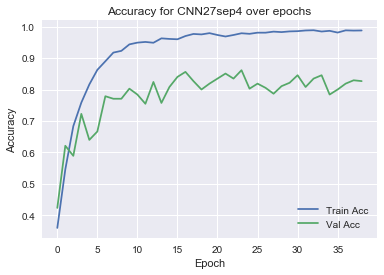

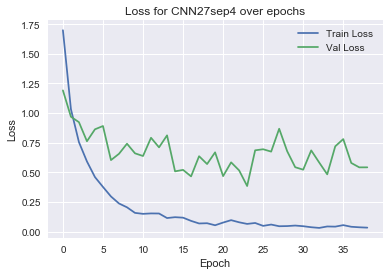

In [10]:
histories = []
modelDepths = []
accuracies = []

for nConvLayers in range(4,5):
       
    model = CNNModel((Xtrain.shape[1],Xtrain.shape[2]),nConvLayers)
    opt = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
    model.compile(optimizer = opt,
             loss='categorical_crossentropy',
             metrics = ['accuracy'])
    model.summary()
   
    modelName = 'CNN27sep'+ str(nConvLayers)
    saveModelTopology(model,modelName)
    model.save(modelName+'CEO.h5')
    
    print('TRAINING...')
    epochs = 150
    history = fitModel(model,modelName, Xtrain, Ytrain, Xval, Yval, epochs)
    histories.append(history.history)   
    modelDepths.append(nConvLayers)
        
    # check how it went
    print(history.history)

    # plot Accuracy over Epochs
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train Acc','Val Acc'])
    plt.title('Accuracy for {} over epochs'.format(modelName))
    plt.show()

    # plot Loss over Epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train Loss','Val Loss'])
    plt.title('Loss for {} over epochs'.format(modelName))
    plt.show()
    
#     acc = evaluateModel(model, modelName, Xval, Yval)
#     accuracies.append(acc)
    
    
    with open("hist.txt", "w") as f:
        for h in histories:
            f.write(str(h) +"\n")

#     with open("hist.txt", "r") as f:
#         for line in f:
#             histo.append(int(line.strip()))